## Imports

In [16]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"  # must be BEFORE torch/TF import
import warnings
warnings.filterwarnings("ignore")
import torch
import torch.optim as optim
import torch.nn.functional as F
from bytelatent.model.blt import ByteLatentTransformerArgs, ByteLatentTransformer
from chronos import MeanScaleUniformBins, ChronosConfig
from utils.train_utils import *
from TLLM_data_provider.data_factory import data_provider
# from data_provider.data_factory import data_provider
import argparse
from tqdm import tqdm
import time
torch.cuda.set_device(0)   # 0 here means “the first visible GPU”, i.e. physical #3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from bytelatent.tokenizers.constants import PAD_ID

## Args

In [17]:
## Training Args
vocab_size = 4096
quant_range = 12
batch_size = 128
seq_len = 96
learning_rate = 5e-4
weight_decay = 1e-2
epochs = 50
grad_accumulation_steps = 1
clip_grad = 1.0
seed = 42
warmup_steps = 0
min_lr_factor = 0.1
decay_lr = True
compile = True
output_dir = "output"
save_every = 5
compile = False
dataset_name = 'ETTh1'
features = 'M'

## Data Loader

In [18]:
def build_dataloader(dataset_name, features, seq_len, label_len, pred_len, flag, batch_size):
    config = {
        'task_name': 'long_term_forecast',
        'dataset': dataset_name,
        'data' : dataset_name,
        'embed' : 'timeF',
        'root_path': 'dataset/ETT-small/',
        'data_path': f'{dataset_name}.csv',
        'features': features,
        'seq_len': seq_len,
        'label_len': label_len,
        'pred_len': pred_len
    }

    args = argparse.Namespace(
        batch_size=batch_size,
        freq='h' if 'h' in dataset_name else 'm',
        num_workers=2,
        subsample_pct=None,
        fix_seed=42,
        target='OT',
        shuffle=True,
        scale=True
    )

    dataset, loader = data_provider(args, config, flag)
    # validate_dataset, validate_loader = data_provider(args, config, flag='val')
    # test_dataset, test_loader = data_provider(args, config, flag='test')
    return dataset, loader

In [19]:
train_dataset, train_loader = build_dataloader(dataset_name, features, seq_len, seq_len - 1, 1, 'train', batch_size)
validate_dataset, validate_loader = build_dataloader(dataset_name, features, seq_len, seq_len - 1, 1, 'test', batch_size)
print(f"Dataset: {dataset_name}, Features: {features}, Batch Size: {batch_size}, Seq Len: {seq_len}")

Dataset: ETTh1, Features: M, Batch Size: 128, Seq Len: 96


In [20]:
len(train_loader), len(validate_loader) 

(624, 624)

In [20]:
config = {
    'task_name': 'long_term_forecast',
    'dataset': dataset_name,
    'data' : dataset_name,
    'embed' : 'timeF',
    'root_path': 'dataset/ETT-small/',
    'data_path': f'{dataset_name}.csv',
    'features': features,
    'seq_len': seq_len,
    'label_len': seq_len - 1,
    'pred_len': 1
}

args = argparse.Namespace(
    batch_size=batch_size,
    freq='h' if 'h' in dataset_name else 'm',
    num_workers=2,
    subsample_pct=None,
    fix_seed=42,
    target='OT',
    shuffle=True,
    scale=True
)

train_dataset, train_loader = data_provider(args, config, flag='train')
validate_dataset, validate_loader = data_provider(args, config, flag='val')
test_dataset, test_loader = data_provider(args, config, flag='test')
len(train_dataset), len(validate_dataset), len(test_dataset)

(79968, 20160, 20160)

## Data Loader Demo

In [11]:
for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(train_loader):
    batch_x = batch_x.to(device)
    batch_y = batch_y.to(device)
    batch_x_mark = batch_x_mark.to(device)
    batch_y_mark = batch_y_mark.to(device)
    x = batch_x.float().squeeze(-1)
    y = batch_y.float().squeeze(-1)
    break
x.shape, y.shape 

(torch.Size([128, 96, 7]), torch.Size([128, 96, 7]))

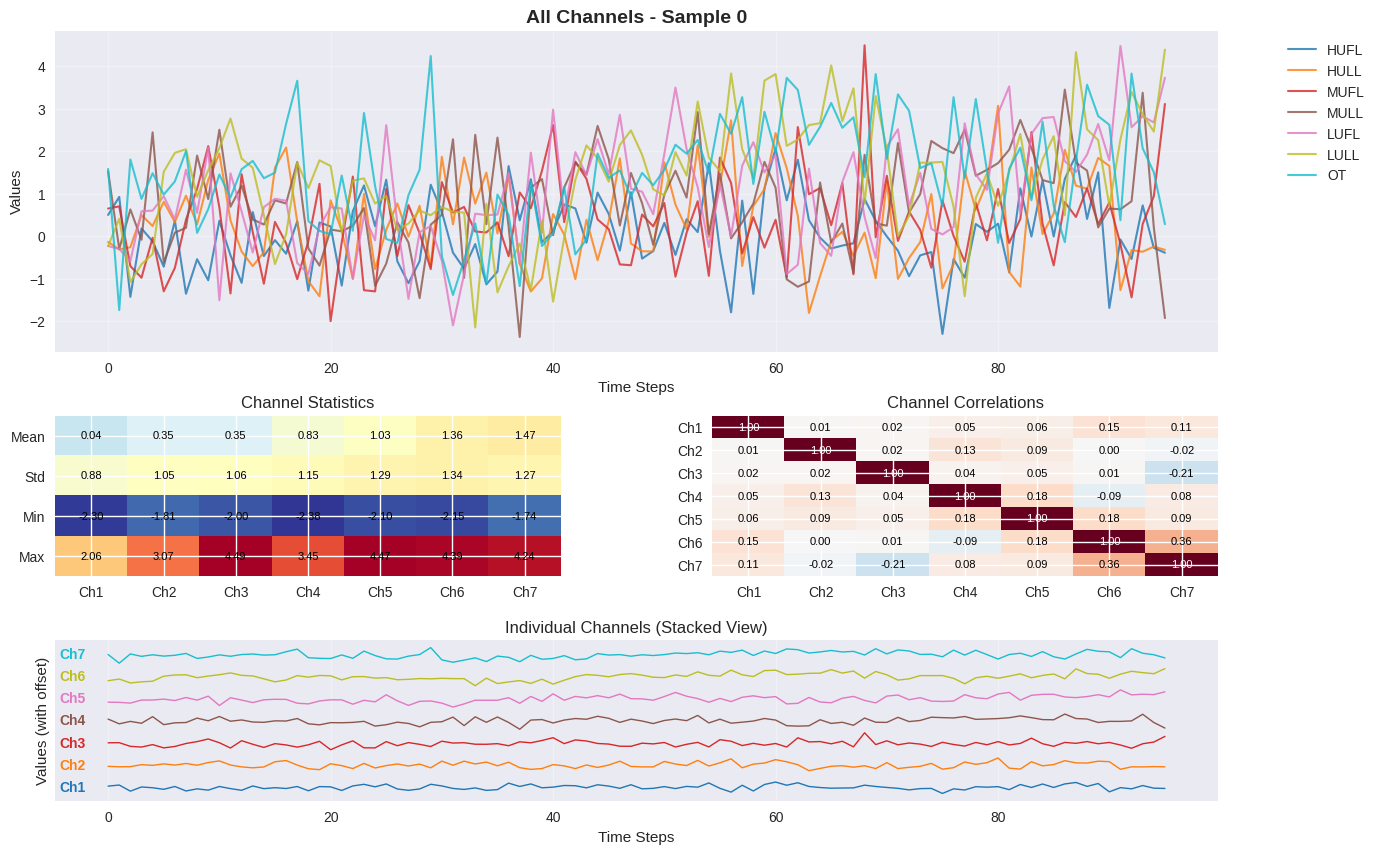

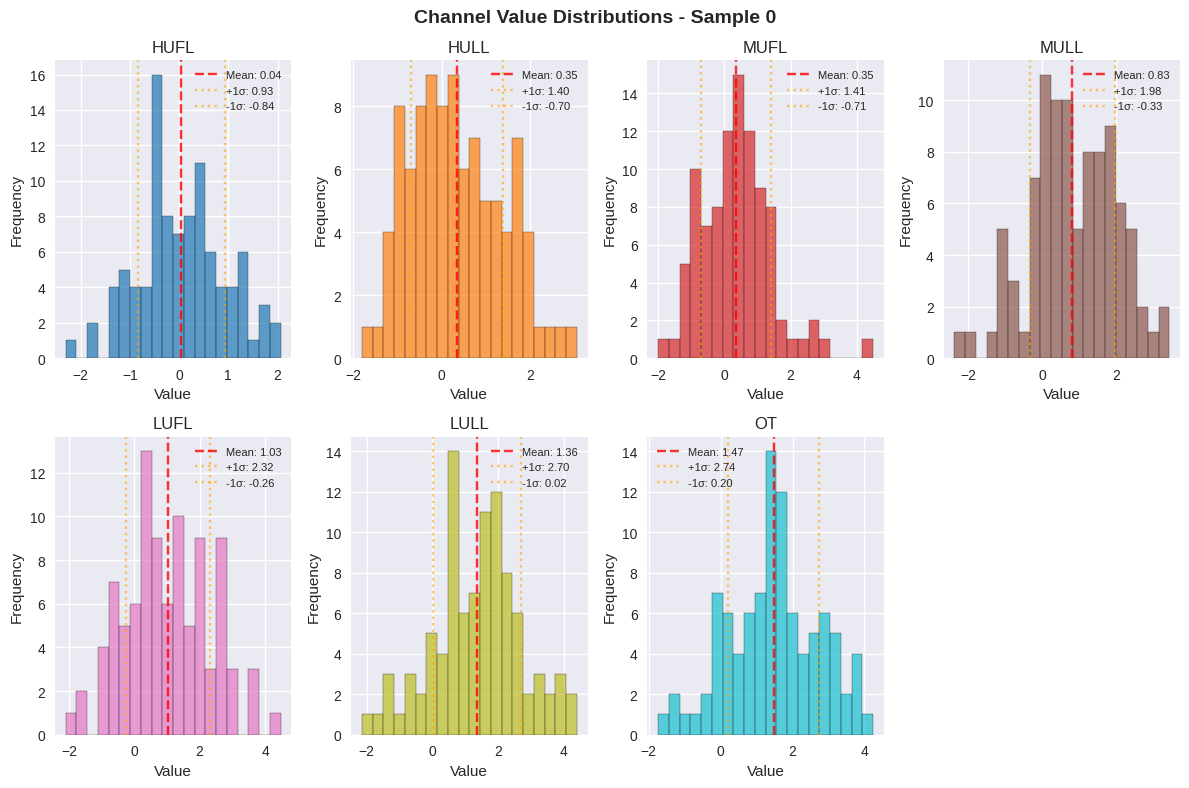

Channel Independence Analysis for Sample 0

Correlation Matrix:
------------------------------
HUFL vs HULL: 0.014
HUFL vs MUFL: 0.020
HUFL vs MULL: 0.050
HUFL vs LUFL: 0.062
HUFL vs LULL: 0.145
HUFL vs OT: 0.107
HULL vs HUFL: 0.014
HULL vs MUFL: 0.019
HULL vs MULL: 0.130
HULL vs LUFL: 0.089
HULL vs LULL: 0.001
HULL vs OT: -0.025
MUFL vs HUFL: 0.020
MUFL vs HULL: 0.019
MUFL vs MULL: 0.037
MUFL vs LUFL: 0.052
MUFL vs LULL: 0.014
MUFL vs OT: -0.214
MULL vs HUFL: 0.050
MULL vs HULL: 0.130
MULL vs MUFL: 0.037
MULL vs LUFL: 0.181
MULL vs LULL: -0.089
MULL vs OT: 0.084
LUFL vs HUFL: 0.062
LUFL vs HULL: 0.089
LUFL vs MUFL: 0.052
LUFL vs MULL: 0.181
LUFL vs LULL: 0.181
LUFL vs OT: 0.090
LULL vs HUFL: 0.145
LULL vs HULL: 0.001
LULL vs MUFL: 0.014
LULL vs MULL: -0.089
LULL vs LUFL: 0.181
LULL vs OT: 0.357
OT vs HUFL: 0.107
OT vs HULL: -0.025
OT vs MUFL: -0.214
OT vs MULL: 0.084
OT vs LUFL: 0.090
OT vs LULL: 0.357

High Correlation Pairs (|r| > 0.7):
----------------------------------------
No hi

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.gridspec import GridSpec

def plot_all_channels(x, sample_idx=0, channel_names=None, figsize=(15, 10)):
    """
    Plot all 7 channels for a single sample in the same plot
    
    Args:
        x: Input tensor/array of shape [batch_size, seq_len, n_channels]
        sample_idx: Which sample to plot (default: 0)
        channel_names: List of channel names (optional)
        figsize: Figure size tuple
    """
    
    # Extract single sample: [seq_len, n_channels]
    sample_data = x[sample_idx]  # Shape: [96, 7]
    seq_len, n_channels = sample_data.shape
    
    # Default channel names if not provided
    if channel_names is None:
        channel_names = [f'Channel {i+1}' for i in range(n_channels)]
    
    # Set up the plotting style
    plt.style.use('seaborn-v0_8' if 'seaborn-v0_8' in plt.style.available else 'default')
    colors = plt.cm.tab10(np.linspace(0, 1, n_channels))
    
    # Create figure with subplots
    fig = plt.figure(figsize=figsize)
    gs = GridSpec(3, 2, figure=fig, height_ratios=[2, 1, 1], hspace=0.3, wspace=0.3)
    
    # Main plot: All channels together
    ax_main = fig.add_subplot(gs[0, :])
    
    time_steps = np.arange(seq_len)
    
    for i in range(n_channels):
        channel_data = sample_data[:, i]
        ax_main.plot(time_steps, channel_data, 
                    color=colors[i], 
                    label=channel_names[i],
                    linewidth=1.5,
                    alpha=0.8)
    
    ax_main.set_title(f'All Channels - Sample {sample_idx}', fontsize=14, fontweight='bold')
    ax_main.set_xlabel('Time Steps')
    ax_main.set_ylabel('Values')
    ax_main.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax_main.grid(True, alpha=0.3)
    
    # Statistics subplot
    ax_stats = fig.add_subplot(gs[1, 0])
    
    # Calculate statistics for each channel
    stats_data = []
    for i in range(n_channels):
        channel_data = sample_data[:, i]
        stats_data.append([
            np.mean(channel_data),
            np.std(channel_data),
            np.min(channel_data),
            np.max(channel_data)
        ])
    
    stats_array = np.array(stats_data)
    stat_names = ['Mean', 'Std', 'Min', 'Max']
    
    # Heatmap of statistics
    im = ax_stats.imshow(stats_array.T, cmap='RdYlBu_r', aspect='auto')
    ax_stats.set_xticks(range(n_channels))
    ax_stats.set_xticklabels([f'Ch{i+1}' for i in range(n_channels)])
    ax_stats.set_yticks(range(len(stat_names)))
    ax_stats.set_yticklabels(stat_names)
    ax_stats.set_title('Channel Statistics')
    
    # Add text annotations
    for i in range(n_channels):
        for j in range(len(stat_names)):
            text = ax_stats.text(i, j, f'{stats_array[i, j]:.2f}',
                               ha="center", va="center", color="black", fontsize=8)
    
    # Correlation heatmap
    ax_corr = fig.add_subplot(gs[1, 1])
    
    # Calculate correlation matrix
    corr_matrix = np.corrcoef(sample_data.T)
    
    im_corr = ax_corr.imshow(corr_matrix, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')
    ax_corr.set_xticks(range(n_channels))
    ax_corr.set_xticklabels([f'Ch{i+1}' for i in range(n_channels)])
    ax_corr.set_yticks(range(n_channels))
    ax_corr.set_yticklabels([f'Ch{i+1}' for i in range(n_channels)])
    ax_corr.set_title('Channel Correlations')
    
    # Add correlation values
    for i in range(n_channels):
        for j in range(n_channels):
            text = ax_corr.text(j, i, f'{corr_matrix[i, j]:.2f}',
                               ha="center", va="center", 
                               color="white" if abs(corr_matrix[i, j]) > 0.5 else "black", 
                               fontsize=8)
    
    # Individual channel plots (smaller)
    ax_individual = fig.add_subplot(gs[2, :])
    
    # Create small multiples for each channel
    for i in range(n_channels):
        offset = i * (np.max(sample_data) - np.min(sample_data)) * 1.2
        channel_data = sample_data[:, i] + offset
        ax_individual.plot(time_steps, channel_data, 
                          color=colors[i], 
                          label=channel_names[i],
                          linewidth=1)
        
        # Add channel label
        ax_individual.text(-2, offset + np.mean(sample_data[:, i]), 
                          f'Ch{i+1}', 
                          va='center', ha='right', 
                          color=colors[i], fontweight='bold')
    
    ax_individual.set_title('Individual Channels (Stacked View)')
    ax_individual.set_xlabel('Time Steps')
    ax_individual.set_ylabel('Values (with offset)')
    ax_individual.grid(True, alpha=0.3)
    ax_individual.set_yticks([])  # Remove y-ticks since they're offset
    
    plt.tight_layout()
    return fig

def plot_channel_distributions(x, sample_idx=0, channel_names=None, figsize=(12, 8)):
    """
    Plot distribution analysis for all channels
    """
    sample_data = x[sample_idx]
    seq_len, n_channels = sample_data.shape
    
    if channel_names is None:
        channel_names = [f'Channel {i+1}' for i in range(n_channels)]
    
    fig, axes = plt.subplots(2, 4, figsize=figsize)
    axes = axes.flatten()
    
    colors = plt.cm.tab10(np.linspace(0, 1, n_channels))
    
    for i in range(n_channels):
        ax = axes[i]
        channel_data = sample_data[:, i]
        
        # Histogram
        ax.hist(channel_data, bins=20, alpha=0.7, color=colors[i], edgecolor='black')
        ax.set_title(f'{channel_names[i]}')
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')
        
        # Add statistics text
        mean_val = np.mean(channel_data)
        std_val = np.std(channel_data)
        ax.axvline(mean_val, color='red', linestyle='--', alpha=0.8, label=f'Mean: {mean_val:.2f}')
        ax.axvline(mean_val + std_val, color='orange', linestyle=':', alpha=0.6, label=f'+1σ: {mean_val + std_val:.2f}')
        ax.axvline(mean_val - std_val, color='orange', linestyle=':', alpha=0.6, label=f'-1σ: {mean_val - std_val:.2f}')
        ax.legend(fontsize=8)
    
    # Remove empty subplot
    if n_channels < len(axes):
        fig.delaxes(axes[-1])
    
    plt.suptitle(f'Channel Value Distributions - Sample {sample_idx}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    return fig

def analyze_channel_independence(x, sample_idx=0, channel_names=None):
    """
    Analyze channel independence for univariate assumption validation
    """
    sample_data = x[sample_idx]
    seq_len, n_channels = sample_data.shape
    
    if channel_names is None:
        channel_names = [f'Channel {i+1}' for i in range(n_channels)]
    
    print(f"Channel Independence Analysis for Sample {sample_idx}")
    print("=" * 50)
    
    # Correlation analysis
    corr_matrix = np.corrcoef(sample_data.T)
    
    print("\nCorrelation Matrix:")
    print("-" * 30)
    for i in range(n_channels):
        for j in range(n_channels):
            if i != j:
                corr_val = corr_matrix[i, j]
                print(f"{channel_names[i]} vs {channel_names[j]}: {corr_val:.3f}")
    
    # High correlation pairs
    high_corr_pairs = []
    threshold = 0.7
    for i in range(n_channels):
        for j in range(i+1, n_channels):
            if abs(corr_matrix[i, j]) > threshold:
                high_corr_pairs.append((i, j, corr_matrix[i, j]))
    
    print(f"\nHigh Correlation Pairs (|r| > {threshold}):")
    print("-" * 40)
    if high_corr_pairs:
        for i, j, corr_val in high_corr_pairs:
            print(f"{channel_names[i]} - {channel_names[j]}: {corr_val:.3f}")
    else:
        print("No high correlation pairs found.")
    
    # Statistics comparison
    print("\nChannel Statistics:")
    print("-" * 20)
    for i in range(n_channels):
        channel_data = sample_data[:, i]
        print(f"{channel_names[i]}:")
        print(f"  Mean: {np.mean(channel_data):.3f}")
        print(f"  Std:  {np.std(channel_data):.3f}")
        print(f"  Range: [{np.min(channel_data):.3f}, {np.max(channel_data):.3f}]")
        print()
    
    return corr_matrix, high_corr_pairs

# Example usage:
def main():
    """
    Example of how to use the plotting functions
    """
    # Simulated data - replace with your actual x[0, :, i] data
    np.random.seed(42)
    batch_size, seq_len, n_channels = 32, 96, 7
    
    # Create synthetic data that mimics real time series
    x = np.random.randn(batch_size, seq_len, n_channels)
    
    # Add some trend and seasonality to make it more realistic
    for i in range(n_channels):
        trend = np.linspace(0, i*0.5, seq_len)
        seasonal = np.sin(2 * np.pi * np.arange(seq_len) / (20 + i*5)) * (0.5 + i*0.1)
        x[:, :, i] += trend + seasonal
    
    # ETT dataset channel names (common for ETT datasets)
    ett_channel_names = ['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT']
    
    # Plot all channels
    fig1 = plot_all_channels(x, sample_idx=0, channel_names=ett_channel_names)
    plt.show()
    
    # Plot distributions
    fig2 = plot_channel_distributions(x, sample_idx=0, channel_names=ett_channel_names)
    plt.show()
    
    # Analyze independence
    corr_matrix, high_corr_pairs = analyze_channel_independence(x, sample_idx=0, channel_names=ett_channel_names)

if __name__ == "__main__":
    main()

In [13]:
len(train_dataset), len(validate_dataset), len(test_dataset)

NameError: name 'test_dataset' is not defined

ETT Minute Dataset Split Analysis
Total data points per month: 2,880
12 months: 34,560 points
4 months: 11,520 points
8 months: 23,040 points
Sequence length: 96

PRETRAIN = True (Self-supervised pretraining)
---------------------------------------------
Train: [0 : 16 months]
  Start: 0, End: 46,080
  Duration: 46,080 points (16.0 months)
Val: [16 months - seq_len : 20 months]
  Start: 45,984, End: 57,600
  Duration: 11,616 points (4.0 months)
Test: [16 months - seq_len : 20 months] (same as val)
  Start: 45,984, End: 57,600
  Duration: 11,616 points (4.0 months)

PRETRAIN = False (Standard supervised learning)
------------------------------------------------
Train: [0 : 12 months]
  Start: 0, End: 34,560
  Duration: 34,560 points (12.0 months)
Val: [12 months - seq_len : 16 months]
  Start: 34,464, End: 46,080
  Duration: 11,616 points (4.0 months)
Test: [16 months - seq_len : 20 months]
  Start: 45,984, End: 57,600
  Duration: 11,616 points (4.0 months)

KEY DIFFERENCES:
-----------

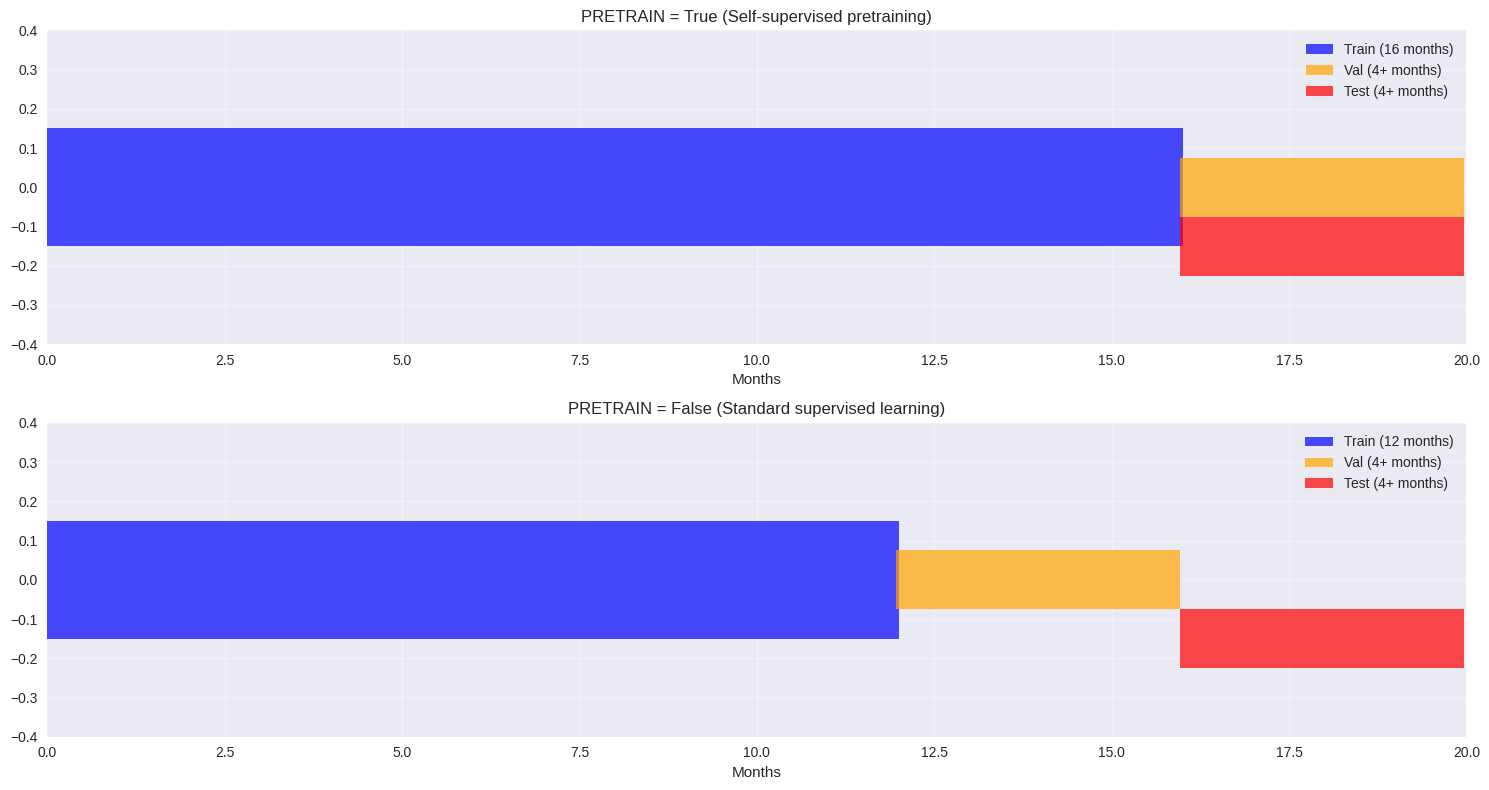


Why does PRETRAIN have overlapping val/test sets?

    In SELF-SUPERVISED PRETRAINING:

    1. GOAL: Learn general time series representations
       - Model learns to predict masked/future values
       - No specific downstream task yet

    2. VAL/TEST OVERLAP is acceptable because:
       - You're not doing task-specific evaluation
       - Focus is on representation learning quality
       - Real evaluation happens during fine-tuning

    3. MORE TRAINING DATA (16 vs 12 months):
       - Self-supervised learning benefits from more data
       - Better representations with longer sequences
       - Can afford to use more data for pretraining

    In STANDARD SUPERVISED LEARNING:

    1. GOAL: Optimize for specific forecasting task
       - Model trained end-to-end for prediction
       - Need proper train/val/test separation

    2. STRICT SEPARATION required:
       - Prevent data leakage
       - Honest evaluation of generalization
       - Standard ML best practices
    

SUMMAR

In [14]:
import numpy as np
import matplotlib.pyplot as plt

def analyze_ett_splits(seq_len=96):
    """
    Analyze the difference between pretrain=True and pretrain=False splits
    for ETT minute dataset
    """
    
    # ETT minute dataset constants
    # 12 months = 12 * 30 * 24 * 4 = 34,560 time points (15-min intervals)
    # 4 months = 4 * 30 * 24 * 4 = 11,520 time points  
    # 8 months = 8 * 30 * 24 * 4 = 23,040 time points
    
    month_minutes = 30 * 24 * 4  # 30 days * 24 hours * 4 (15-min intervals)
    
    # Calculate boundaries
    twelve_months = 12 * month_minutes  # 34,560
    four_months = 4 * month_minutes     # 11,520  
    eight_months = 8 * month_minutes    # 23,040
    
    print("ETT Minute Dataset Split Analysis")
    print("=" * 50)
    print(f"Total data points per month: {month_minutes:,}")
    print(f"12 months: {twelve_months:,} points")
    print(f"4 months: {four_months:,} points") 
    print(f"8 months: {eight_months:,} points")
    print(f"Sequence length: {seq_len}")
    print()
    
    # PRETRAIN = True splits
    print("PRETRAIN = True (Self-supervised pretraining)")
    print("-" * 45)
    
    pretrain_border1s = [
        0,  # Train start
        twelve_months + four_months - seq_len,  # Val start  
        twelve_months + four_months - seq_len   # Test start (same as val)
    ]
    pretrain_border2s = [
        twelve_months + four_months,  # Train end (16 months)
        twelve_months + eight_months, # Val end (20 months) 
        twelve_months + eight_months  # Test end (20 months)
    ]
    
    print("Train: [0 : 16 months]")
    print(f"  Start: 0, End: {pretrain_border2s[0]:,}")
    print(f"  Duration: {pretrain_border2s[0]:,} points ({pretrain_border2s[0]/month_minutes:.1f} months)")
    
    print("Val: [16 months - seq_len : 20 months]") 
    print(f"  Start: {pretrain_border1s[1]:,}, End: {pretrain_border2s[1]:,}")
    print(f"  Duration: {pretrain_border2s[1] - pretrain_border1s[1]:,} points ({(pretrain_border2s[1] - pretrain_border1s[1])/month_minutes:.1f} months)")
    
    print("Test: [16 months - seq_len : 20 months] (same as val)")
    print(f"  Start: {pretrain_border1s[2]:,}, End: {pretrain_border2s[2]:,}")
    print(f"  Duration: {pretrain_border2s[2] - pretrain_border1s[2]:,} points ({(pretrain_border2s[2] - pretrain_border1s[2])/month_minutes:.1f} months)")
    print()
    
    # PRETRAIN = False splits  
    print("PRETRAIN = False (Standard supervised learning)")
    print("-" * 48)
    
    normal_border1s = [
        0,  # Train start
        twelve_months - seq_len,  # Val start
        twelve_months + four_months - seq_len  # Test start
    ]
    normal_border2s = [
        twelve_months,  # Train end (12 months)
        twelve_months + four_months,  # Val end (16 months)
        twelve_months + eight_months  # Test end (20 months) 
    ]
    
    print("Train: [0 : 12 months]")
    print(f"  Start: 0, End: {normal_border2s[0]:,}")
    print(f"  Duration: {normal_border2s[0]:,} points ({normal_border2s[0]/month_minutes:.1f} months)")
    
    print("Val: [12 months - seq_len : 16 months]")
    print(f"  Start: {normal_border1s[1]:,}, End: {normal_border2s[1]:,}")
    print(f"  Duration: {normal_border2s[1] - normal_border1s[1]:,} points ({(normal_border2s[1] - normal_border1s[1])/month_minutes:.1f} months)")
    
    print("Test: [16 months - seq_len : 20 months]")
    print(f"  Start: {normal_border1s[2]:,}, End: {normal_border2s[2]:,}")
    print(f"  Duration: {normal_border2s[2] - normal_border1s[2]:,} points ({(normal_border2s[2] - normal_border1s[2])/month_minutes:.1f} months)")
    print()
    
    # Key differences
    print("KEY DIFFERENCES:")
    print("-" * 16)
    train_diff = pretrain_border2s[0] - normal_border2s[0]
    print(f"• Training data: Pretrain uses {train_diff:,} MORE points ({train_diff/month_minutes:.1f} more months)")
    print(f"• Val/Test overlap: Pretrain has OVERLAPPING val/test sets")
    print(f"• Purpose: Pretrain optimized for self-supervised learning")
    print()
    
    # Visualization
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8))
    
    # Timeline in months
    total_months = 20
    months = np.arange(total_months + 1)
    
    # Pretrain splits
    ax1.barh(0, 16, left=0, height=0.3, color='blue', alpha=0.7, label='Train (16 months)')
    ax1.barh(0, 4, left=16-seq_len/month_minutes, height=0.15, color='orange', alpha=0.7, label='Val (4+ months)')  
    ax1.barh(-0.15, 4, left=16-seq_len/month_minutes, height=0.15, color='red', alpha=0.7, label='Test (4+ months)')
    ax1.set_xlim(0, 20)
    ax1.set_ylim(-0.4, 0.4)
    ax1.set_xlabel('Months')
    ax1.set_title('PRETRAIN = True (Self-supervised pretraining)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Normal splits
    ax2.barh(0, 12, left=0, height=0.3, color='blue', alpha=0.7, label='Train (12 months)')
    ax2.barh(0, 4, left=12-seq_len/month_minutes, height=0.15, color='orange', alpha=0.7, label='Val (4+ months)')
    ax2.barh(-0.15, 4, left=16-seq_len/month_minutes, height=0.15, color='red', alpha=0.7, label='Test (4+ months)')
    ax2.set_xlim(0, 20)
    ax2.set_ylim(-0.4, 0.4) 
    ax2.set_xlabel('Months')
    ax2.set_title('PRETRAIN = False (Standard supervised learning)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return {
        'pretrain_splits': {
            'train': (pretrain_border1s[0], pretrain_border2s[0]),
            'val': (pretrain_border1s[1], pretrain_border2s[1]), 
            'test': (pretrain_border1s[2], pretrain_border2s[2])
        },
        'normal_splits': {
            'train': (normal_border1s[0], normal_border2s[0]),
            'val': (normal_border1s[1], normal_border2s[1]),
            'test': (normal_border1s[2], normal_border2s[2])
        }
    }

def why_pretrain_overlap():
    """
    Explain why pretrain has overlapping val/test sets
    """
    print("\nWhy does PRETRAIN have overlapping val/test sets?")
    print("=" * 50)
    print("""
    In SELF-SUPERVISED PRETRAINING:
    
    1. GOAL: Learn general time series representations
       - Model learns to predict masked/future values
       - No specific downstream task yet
       
    2. VAL/TEST OVERLAP is acceptable because:
       - You're not doing task-specific evaluation
       - Focus is on representation learning quality
       - Real evaluation happens during fine-tuning
       
    3. MORE TRAINING DATA (16 vs 12 months):
       - Self-supervised learning benefits from more data
       - Better representations with longer sequences
       - Can afford to use more data for pretraining
    
    In STANDARD SUPERVISED LEARNING:
    
    1. GOAL: Optimize for specific forecasting task
       - Model trained end-to-end for prediction
       - Need proper train/val/test separation
       
    2. STRICT SEPARATION required:
       - Prevent data leakage
       - Honest evaluation of generalization
       - Standard ML best practices
    """)

if __name__ == "__main__":
    # Analyze with default sequence length
    splits = analyze_ett_splits(seq_len=96)
    
    # Explain the rationale
    why_pretrain_overlap()
    
    print("\nSUMMARY:")
    print("• pretrain=True: More training data, overlapping val/test (for self-supervised pretraining)")
    print("• pretrain=False: Standard splits with proper separation (for supervised learning)")
    print("• Your ByteLatent training likely uses pretrain=True for representation learning")

ETT DataLoader Iteration Analysis
Sequence length: 96
Total time points: 1000
Number of channels: 7
Valid positions per channel: 904
Total dataset length: 6328

Index Mapping (from __getitem__):
-----------------------------------
Index    0: Channel 0, Time [  0: 96]
Index    1: Channel 0, Time [  1: 97]
Index    2: Channel 0, Time [  2: 98]
Index  903: Channel 0, Time [903:999]
Index  904: Channel 1, Time [  0: 96]
Index  905: Channel 1, Time [  1: 97]
Index 6327: Channel 6, Time [903:999]

Channel-by-Channel Breakdown:
------------------------------
Channel 0:
  Dataset indices: [   0 :  903]
  First sequence:  Time [  0 :  96]
  Last sequence:   Time [903 : 999]

Channel 1:
  Dataset indices: [ 904 : 1807]
  First sequence:  Time [  0 :  96]
  Last sequence:   Time [903 : 999]

Channel 2:
  Dataset indices: [1808 : 2711]
  First sequence:  Time [  0 :  96]
  Last sequence:   Time [903 : 999]

Channel 3:
  Dataset indices: [2712 : 3615]
  First sequence:  Time [  0 :  96]
  Last seq

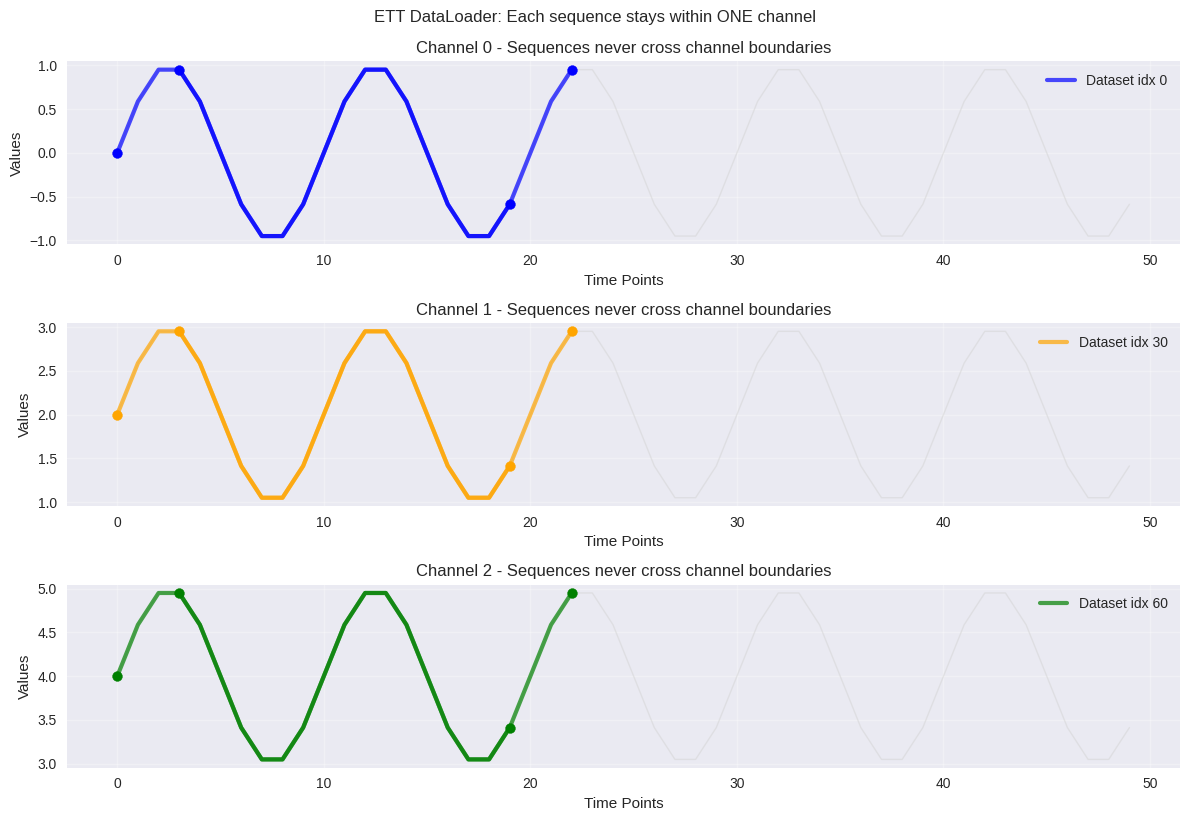

In [15]:
import numpy as np
import matplotlib.pyplot as plt

def analyze_dataloader_iteration():
    """
    Analyze how the ETT dataloader iterates through channels and time
    """
    
    # Example parameters
    seq_len = 96
    pred_len = 1
    total_time_points = 1000
    n_channels = 7
    
    # Calculate dataset parameters (from ETT code)
    tot_len = total_time_points - seq_len - pred_len + 1  # Valid starting positions per channel
    dataset_len = tot_len * n_channels  # Total dataset length
    
    print("ETT DataLoader Iteration Analysis")
    print("=" * 40)
    print(f"Sequence length: {seq_len}")
    print(f"Total time points: {total_time_points}")
    print(f"Number of channels: {n_channels}")
    print(f"Valid positions per channel: {tot_len}")
    print(f"Total dataset length: {dataset_len}")
    print()
    
    # Show how index mapping works
    print("Index Mapping (from __getitem__):")
    print("-" * 35)
    
    sample_indices = [0, 1, 2, tot_len-1, tot_len, tot_len+1, dataset_len-1]
    
    for idx in sample_indices:
        feat_id = idx // tot_len  # Which channel
        s_begin = idx % tot_len   # Starting time position within that channel
        s_end = s_begin + seq_len
        
        print(f"Index {idx:4d}: Channel {feat_id}, Time [{s_begin:3d}:{s_end:3d}]")
    
    print()
    
    # Detailed channel-by-channel breakdown
    print("Channel-by-Channel Breakdown:")
    print("-" * 30)
    
    for channel in range(n_channels):
        start_idx = channel * tot_len
        end_idx = (channel + 1) * tot_len - 1
        
        # First and last sequence for this channel
        first_time_start = 0
        first_time_end = seq_len
        last_time_start = tot_len - 1
        last_time_end = last_time_start + seq_len
        
        print(f"Channel {channel}:")
        print(f"  Dataset indices: [{start_idx:4d} : {end_idx:4d}]")
        print(f"  First sequence:  Time [{first_time_start:3d} : {first_time_end:3d}]")
        print(f"  Last sequence:   Time [{last_time_start:3d} : {last_time_end:3d}]")
        print()
    
    return tot_len, dataset_len

def visualize_channel_iteration():
    """
    Visualize how sequences are sampled from each channel
    """
    seq_len = 20  # Smaller for visualization
    total_time_points = 50
    n_channels = 3  # Fewer channels for clarity
    
    tot_len = total_time_points - seq_len - 1 + 1  # 30 valid positions
    
    fig, axes = plt.subplots(n_channels, 1, figsize=(12, 8))
    
    colors = ['blue', 'orange', 'green']
    
    for channel in range(n_channels):
        ax = axes[channel]
        
        # Draw the full time series for this channel
        time_points = np.arange(total_time_points)
        channel_data = np.sin(2 * np.pi * time_points / 10) + channel * 2
        ax.plot(time_points, channel_data, color='lightgray', alpha=0.5, linewidth=1)
        
        # Show first few sequences from this channel
        for seq_idx in range(0, min(5, tot_len), max(1, tot_len//10)):
            start_time = seq_idx
            end_time = start_time + seq_len
            
            # Highlight the sequence
            seq_times = np.arange(start_time, end_time)
            seq_values = channel_data[start_time:end_time]
            
            dataset_idx = channel * tot_len + seq_idx
            
            ax.plot(seq_times, seq_values, color=colors[channel], linewidth=3, alpha=0.7,
                   label=f'Dataset idx {dataset_idx}' if seq_idx < 2 else '')
            
            # Mark start and end
            ax.scatter([start_time, end_time-1], [seq_values[0], seq_values[-1]], 
                      color=colors[channel], s=50, zorder=5)
        
        ax.set_title(f'Channel {channel} - Sequences never cross channel boundaries')
        ax.set_xlabel('Time Points')
        ax.set_ylabel('Values')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.suptitle('ETT DataLoader: Each sequence stays within ONE channel', y=1.02)
    plt.show()

def demonstrate_no_mixing():
    """
    Demonstrate that channels never mix
    """
    print("PROOF: No Channel Mixing")
    print("=" * 25)
    print("""
    From the __getitem__ method:
    
    def __getitem__(self, index):
        feat_id = index // self.tot_len     # Which channel (0, 1, 2, ..., 6)
        s_begin = index % self.tot_len      # Time start within that channel
        
        s_end = s_begin + self.seq_len      # Time end within SAME channel
        
        # Key: Only extract from ONE channel
        seq_x = self.data_x[s_begin:s_end, feat_id:feat_id + 1]
                           ^^^^^^^^^^^^^^^  ^^^^^^^^^^^^^^^^^
                           Time slice       Single channel only
    
    IMPORTANT BOUNDARIES:
    """)
    
    # Example with real numbers
    seq_len = 96
    tot_len = 1000  # Example
    n_channels = 7
    
    for channel in range(min(3, n_channels)):  # Show first 3 channels
        channel_start_idx = channel * tot_len
        channel_end_idx = (channel + 1) * tot_len - 1
        
        # Last valid sequence for this channel
        last_seq_start_time = tot_len - 1  # 999
        last_seq_end_time = last_seq_start_time + seq_len  # 1095
        
        print(f"Channel {channel}:")
        print(f"  Dataset indices: [{channel_start_idx} : {channel_end_idx}]")
        print(f"  Last sequence: Time [{last_seq_start_time} : {last_seq_end_time}] (within channel {channel})")
        print(f"  Max time index: {tot_len + seq_len - 2} (still within channel {channel} data)")
        print()
    
    print("CONCLUSION:")
    print("• Each sequence is ENTIRELY from one channel")
    print("• Time boundaries are respected within each channel") 
    print("• NO mixing between channels occurs")
    print("• Each channel is treated as independent time series")

if __name__ == "__main__":
    # Analyze the iteration pattern
    tot_len, dataset_len = analyze_dataloader_iteration()
    
    print("\n" + "="*50)
    
    # Demonstrate no mixing
    demonstrate_no_mixing()
    
    print("\n" + "="*50)
    
    # Visualize the pattern
    visualize_channel_iteration()

ANALYSIS FOR YOUR PARAMETERS:
Batch-Channel Distribution Analysis
Batch size: 64
Sequence length: 96
Total time points: 10000
Number of channels: 7
Valid positions per channel (tot_len): 9904
Total dataset length: 69328
Number of batches: 1083

DETAILED BATCH ANALYSIS:
-------------------------
Batch 0: Dataset indices [0:63]
  Channels present: [0]
  Channel distribution: {0: 64}
  Sample details (first 5):
    Sample 0: Dataset[0] = Channel 0, Time [0:96]
    Sample 1: Dataset[1] = Channel 0, Time [1:97]
    Sample 2: Dataset[2] = Channel 0, Time [2:98]
    Sample 3: Dataset[3] = Channel 0, Time [3:99]
    Sample 4: Dataset[4] = Channel 0, Time [4:100]
    ... and 59 more samples

Batch 1: Dataset indices [64:127]
  Channels present: [0]
  Channel distribution: {0: 64}
  Sample details (first 5):
    Sample 0: Dataset[64] = Channel 0, Time [64:160]
    Sample 1: Dataset[65] = Channel 0, Time [65:161]
    Sample 2: Dataset[66] = Channel 0, Time [66:162]
    Sample 3: Dataset[67] = Cha

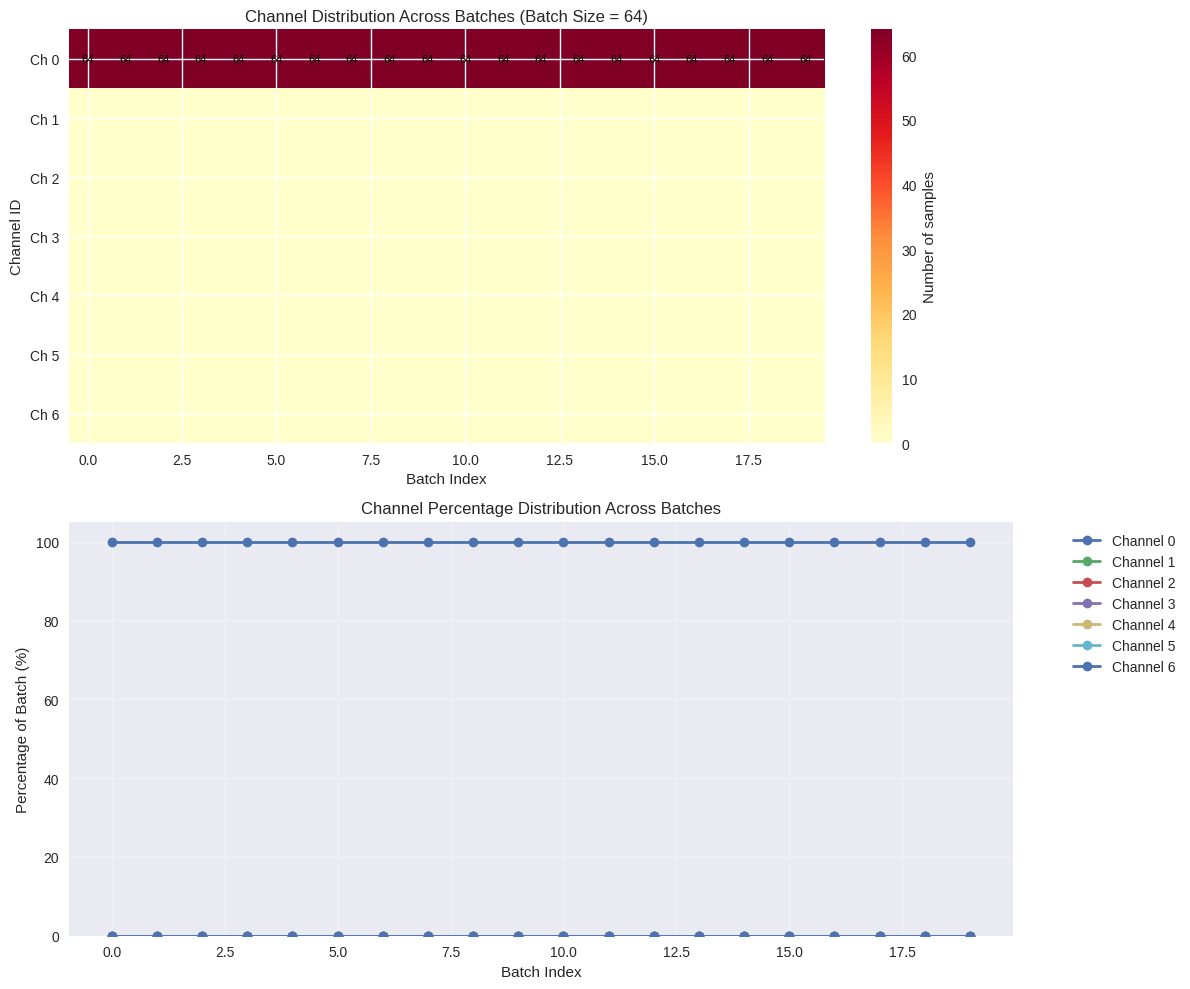

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

def analyze_batch_channel_distribution(batch_size=64, seq_len=96, total_time_points=10000, n_channels=7):
    """
    Analyze how channels are distributed across batches in ETT dataloader
    """
    
    # Calculate ETT dataset parameters
    tot_len = total_time_points - seq_len - 1 + 1  # Valid starting positions per channel
    dataset_len = tot_len * n_channels  # Total dataset length
    
    print("Batch-Channel Distribution Analysis")
    print("=" * 40)
    print(f"Batch size: {batch_size}")
    print(f"Sequence length: {seq_len}")
    print(f"Total time points: {total_time_points}")
    print(f"Number of channels: {n_channels}")
    print(f"Valid positions per channel (tot_len): {tot_len}")
    print(f"Total dataset length: {dataset_len}")
    print(f"Number of batches: {dataset_len // batch_size}")
    print()
    
    # Analyze first few batches in detail
    print("DETAILED BATCH ANALYSIS:")
    print("-" * 25)
    
    for batch_idx in range(min(10, dataset_len // batch_size)):
        batch_start_idx = batch_idx * batch_size
        batch_end_idx = batch_start_idx + batch_size
        
        channels_in_batch = []
        time_ranges = []
        
        print(f"Batch {batch_idx}: Dataset indices [{batch_start_idx}:{batch_end_idx-1}]")
        
        for sample_idx in range(batch_start_idx, min(batch_end_idx, dataset_len)):
            # ETT's index mapping
            feat_id = sample_idx // tot_len  # Which channel
            s_begin = sample_idx % tot_len   # Time position within channel
            s_end = s_begin + seq_len
            
            channels_in_batch.append(feat_id)
            time_ranges.append((s_begin, s_end))
        
        # Count channels in this batch
        channel_counts = Counter(channels_in_batch)
        
        print(f"  Channels present: {sorted(channel_counts.keys())}")
        print(f"  Channel distribution: {dict(channel_counts)}")
        
        # Show time ranges for first few samples
        print(f"  Sample details (first 5):")
        for i, (channel, (start, end)) in enumerate(zip(channels_in_batch[:5], time_ranges[:5])):
            dataset_idx = batch_start_idx + i
            print(f"    Sample {i}: Dataset[{dataset_idx}] = Channel {channel}, Time [{start}:{end}]")
        
        if len(channels_in_batch) > 5:
            print(f"    ... and {len(channels_in_batch) - 5} more samples")
        print()
    
    return tot_len, dataset_len

def calculate_channel_transition_points(batch_size=64, seq_len=96, total_time_points=10000, n_channels=7):
    """
    Calculate exactly where channel transitions occur in batches
    """
    
    tot_len = total_time_points - seq_len - 1 + 1
    
    print("CHANNEL TRANSITION ANALYSIS:")
    print("-" * 32)
    
    # Find transition points
    transition_batches = []
    
    for channel in range(n_channels - 1):  # 0 to 5 (transition from channel i to i+1)
        # Last index of current channel
        last_idx_current = (channel + 1) * tot_len - 1
        # First index of next channel  
        first_idx_next = (channel + 1) * tot_len
        
        # Which batches do these fall into?
        batch_last_current = last_idx_current // batch_size
        batch_first_next = first_idx_next // batch_size
        
        print(f"Channel {channel} → Channel {channel + 1}:")
        print(f"  Last index of Channel {channel}: {last_idx_current} (Batch {batch_last_current})")
        print(f"  First index of Channel {channel + 1}: {first_idx_next} (Batch {batch_first_next})")
        
        if batch_last_current == batch_first_next:
            print(f"  ⚠️  MIXED BATCH: Batch {batch_last_current} contains BOTH channels {channel} and {channel + 1}")
            
            # Calculate exact positions in the mixed batch
            pos_in_batch_last = last_idx_current % batch_size
            pos_in_batch_first = first_idx_next % batch_size
            
            print(f"     Channel {channel} samples: positions 0 to {pos_in_batch_last}")
            print(f"     Channel {channel + 1} samples: positions {pos_in_batch_first} to {batch_size - 1}")
            
            transition_batches.append({
                'batch_idx': batch_last_current,
                'from_channel': channel,
                'to_channel': channel + 1,
                'split_position': pos_in_batch_first
            })
        else:
            print(f"  ✅ CLEAN: Channels {channel} and {channel + 1} in separate batches")
        print()
    
    return transition_batches

def visualize_batch_channel_distribution(batch_size=64, seq_len=96, total_time_points=1000, n_channels=7):
    """
    Visualize how channels are distributed across batches
    """
    
    tot_len = total_time_points - seq_len - 1 + 1
    dataset_len = tot_len * n_channels
    n_batches = min(20, dataset_len // batch_size)  # Show first 20 batches
    
    # Create batch-channel matrix
    batch_channel_matrix = np.zeros((n_batches, n_channels))
    
    for batch_idx in range(n_batches):
        batch_start_idx = batch_idx * batch_size
        batch_end_idx = min(batch_start_idx + batch_size, dataset_len)
        
        for sample_idx in range(batch_start_idx, batch_end_idx):
            feat_id = sample_idx // tot_len
            if feat_id < n_channels:
                batch_channel_matrix[batch_idx, feat_id] += 1
    
    # Plot heatmap
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Heatmap of channel counts per batch
    im1 = ax1.imshow(batch_channel_matrix.T, cmap='YlOrRd', aspect='auto')
    ax1.set_xlabel('Batch Index')
    ax1.set_ylabel('Channel ID')
    ax1.set_title(f'Channel Distribution Across Batches (Batch Size = {batch_size})')
    ax1.set_yticks(range(n_channels))
    ax1.set_yticklabels([f'Ch {i}' for i in range(n_channels)])
    
    # Add text annotations
    for i in range(n_batches):
        for j in range(n_channels):
            if batch_channel_matrix[i, j] > 0:
                text = ax1.text(i, j, f'{int(batch_channel_matrix[i, j])}',
                               ha="center", va="center", color="black", fontsize=8)
    
    plt.colorbar(im1, ax=ax1, label='Number of samples')
    
    # Line plot showing channel transitions
    channel_ratios = batch_channel_matrix / batch_size * 100  # Convert to percentages
    
    for channel in range(n_channels):
        ax2.plot(range(n_batches), channel_ratios[:, channel], 
                marker='o', label=f'Channel {channel}', linewidth=2)
    
    ax2.set_xlabel('Batch Index')
    ax2.set_ylabel('Percentage of Batch (%)')
    ax2.set_title('Channel Percentage Distribution Across Batches')
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(0, 105)
    
    plt.tight_layout()
    plt.show()
    
    return batch_channel_matrix

def practical_implications(batch_size=64, seq_len=96, total_time_points=10000, n_channels=7):
    """
    Explain practical implications for training and evaluation
    """
    
    tot_len = total_time_points - seq_len - 1 + 1
    
    print("PRACTICAL IMPLICATIONS:")
    print("=" * 23)
    
    print("1. TRAINING IMPLICATIONS:")
    print("   • Each batch may contain MIXED channels")
    print("   • Model sees different channels within same batch")
    print("   • Gradient updates aggregate across multiple channels")
    print("   • This is actually GOOD for learning diverse patterns")
    print()
    
    print("2. EVALUATION IMPLICATIONS:")
    print("   • Need to track which samples belong to which channel")
    print("   • Can't assume batch = single channel")
    print("   • Must use feat_id calculation for channel identification")
    print()
    
    print("3. BATCH SIZE EFFECTS:")
    smaller_batch = 32
    larger_batch = 128
    
    # Calculate transitions for different batch sizes
    for bs in [smaller_batch, batch_size, larger_batch]:
        mixed_batches = 0
        for channel in range(n_channels - 1):
            last_idx = (channel + 1) * tot_len - 1
            first_idx = (channel + 1) * tot_len
            if last_idx // bs == first_idx // bs:
                mixed_batches += 1
        
        print(f"   Batch size {bs}: {mixed_batches}/{n_channels-1} transitions create mixed batches")
    
    print()
    print("4. RECOMMENDATIONS:")
    print("   ✅ Use the provided evaluation code to handle mixed batches")
    print("   ✅ Track channel_id for each sample during inference")
    print("   ✅ Consider batch_size impact on channel mixing")
    print("   ⚠️  Don't assume batch contains only one channel")

if __name__ == "__main__":
    # Example with your parameters
    batch_size = 64
    seq_len = 96
    total_time_points = 10000  # Example ETT dataset size
    n_channels = 7
    
    print("ANALYSIS FOR YOUR PARAMETERS:")
    print("=" * 35)
    
    # Detailed analysis
    tot_len, dataset_len = analyze_batch_channel_distribution(batch_size, seq_len, total_time_points, n_channels)
    
    print("\n" + "="*50)
    
    # Transition analysis
    transitions = calculate_channel_transition_points(batch_size, seq_len, total_time_points, n_channels)
    
    print("\n" + "="*50)
    
    # Practical implications
    practical_implications(batch_size, seq_len, total_time_points, n_channels)
    
    print("\n" + "="*50)
    
    # Visualization
    print("GENERATING VISUALIZATION...")
    batch_channel_matrix = visualize_batch_channel_distribution(batch_size, seq_len, 2000, n_channels)  # Smaller dataset for vis

## Model

In [27]:
model_args = ByteLatentTransformerArgs(
    seed=42,
    vocab_size=vocab_size,                       # Small byte-level vocab
    max_length=seq_len,                        # Max full sequence length
    max_seqlen=seq_len,
    max_encoder_seq_length=seq_len,
    local_attention_window_len=seq_len,        # Local window, 128 is sufficient for small models

    dim_global=64,                        # Lower than default 512
    dim_local_encoder=32,
    dim_local_decoder=32,

    n_layers_global=2,
    n_layers_local_encoder=2,
    n_layers_local_decoder=2,

    n_heads_global=2,                      # Reduce heads
    n_heads_local_encoder=2,
    n_heads_local_decoder=2,

    patch_size=4,
    patch_in_forward=False,                # Patch in forward pass
    patching_batch_size=256,
    patching_device="cuda",               # Use CPU for patching in small model
    patching_mode="entropy",
    patching_threshold=3.0,
    max_patch_length=16,
    monotonicity=True,            # Monotonic patching
    pad_to_max_length=True,

    cross_attn_encoder=True,
    cross_attn_decoder=True,
    cross_attn_k=2,
    cross_attn_nheads=2,
    cross_attn_all_layers_encoder=True,
    cross_attn_all_layers_decoder=True,
    cross_attn_use_flex_attention=False,
    cross_attn_init_by_pooling=True,

    encoder_hash_byte_group_size=[8,9,10],   # Fewer hash sizes
    encoder_hash_byte_group_vocab=2**8,
    encoder_hash_byte_group_nb_functions=1,
    encoder_enable_byte_ngrams=False,

    non_linearity="swiglu",
    use_rope=True,
    attn_impl="sdpa",                      # Efficient PyTorch attention
    attn_bias_type="causal",

    dropout=0.1,
    layer_ckpt="none",                     # No checkpointing in small model
    init_use_gaussian=True,
    init_use_depth="current",
    alpha_depth="disabled",
    log_patch_lengths=True,

    downsampling_by_pooling="max",         # Efficient downsampling
    use_local_encoder_transformer=True,
    share_encoder_decoder_emb=True         # Save memory if possible
)


In [28]:
model = ByteLatentTransformer(model_args)
model = model.to(device)
if compile:
    model = torch.compile(model)

# n of params in model in millions
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of parameters in model: {count_parameters(model) / 1e6:.2f}M")

Number of parameters in model: 0.36M


In [29]:
def create_static_patch_lengths(batch_size, seq_len, patch_length=8):
    if seq_len == 336:
        n_patches = 43
    elif seq_len == 96:
        n_patches = 13
    elif seq_len == 512:
        n_patches = 65
    elif seq_len == 256:
        n_patches = 33
    elif seq_len == 192:
        n_patches = 13
    elif seq_len == 720:
        n_patches = 91
    else:
        raise ValueError(f"Unsupported seq_len: {seq_len}")

    l = torch.full((batch_size,n_patches), patch_length).to('cuda')
    l[:,0] = 1
    l[:,1] = patch_length - 1
    patch_lengths = l
    return patch_lengths

In [30]:
patch_lengths = create_static_patch_lengths(batch_size=batch_size, seq_len=seq_len)
patch_lengths.shape, patch_lengths[0].sum().item()

(torch.Size([128, 13]), 96)

In [31]:
optimizer = optim.AdamW(
        model.parameters(), 
        lr=5e-4, 
        weight_decay=0.01,
        betas=(0.9, 0.95)  # Use better beta values from first code
    )
optimizer.zero_grad(set_to_none=True)

In [32]:
torch.manual_seed(model_args.seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(model_args.seed)
torch.set_float32_matmul_precision('high')
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16'
scaler = torch.amp.GradScaler(enabled=(dtype == 'float16'))
print(f"Using precision: {dtype}")

Using precision: bfloat16


## Tokenizer

In [12]:
def build_tokenizer(quant_range, vocab_size, context_length, prediction_length):
    """
    Build a tokenizer that maps byte values to tokens.
    """
    # Create a new config with prediction_length=1
    low_limit = -1 * quant_range
    high_limit = quant_range

    train_tokenizer_config = ChronosConfig(
        tokenizer_class='MeanScaleUniformBins',
        tokenizer_kwargs={'low_limit': low_limit, 'high_limit': high_limit},
        context_length=seq_len,
        prediction_length=seq_len,   
        n_tokens=vocab_size,
        n_special_tokens=4,
        pad_token_id=-1,
        eos_token_id=0,
        use_eos_token=False,
        model_type='causal',
        num_samples=1,
        temperature=1.0,
        top_k=50,
        top_p=1.0
    )

    # Create a new tokenizer with the updated config
    tokenizer = MeanScaleUniformBins(low_limit, high_limit, train_tokenizer_config)
    return tokenizer

In [ ]:
tokenizer = build_tokenizer(
    quant_range=quant_range,
    vocab_size=vocab_size,
    context_length=seq_len,
    prediction_length=seq_len
)

In [33]:
# Create a new config with prediction_length=1
low_limit = -1 * 15
high_limit = 15

train_tokenizer_config = ChronosConfig(
    tokenizer_class='MeanScaleUniformBins',
    tokenizer_kwargs={'low_limit': low_limit, 'high_limit': high_limit},
    context_length=seq_len,
    prediction_length=seq_len,   
    n_tokens=vocab_size,
    n_special_tokens=4,
    pad_token_id=-1,
    eos_token_id=0,
    use_eos_token=False,
    model_type='causal',
    num_samples=1,
    temperature=1.0,
    top_k=50,
    top_p=1.0
)

# Create a new tokenizer with the updated config
tokenizer = MeanScaleUniformBins(low_limit, high_limit, train_tokenizer_config)

## Train Loop

In [34]:
num_batches = len(train_loader)
total_steps = epochs * num_batches
min_lr = learning_rate * min_lr_factor
best_val_loss = float('inf')

# Training loop with validation
for epoch in range(epochs):
    # Training phase
    model.train()
    t1 = time.time()
    epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1} Training", position=0, leave=True)
    
    for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in progress_bar:

        iteration = epoch * num_batches + i
        x = batch_x.float().squeeze(-1)
        y = batch_y.float().squeeze(-1)
        
        # Get learning rate
        lr = get_lr(
            iteration,
            total_steps,
            warmup_steps,
            learning_rate,
            min_lr,
            decay_lr
        )
        
        # Update learning rate
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
            
        total_loss = 0
        optimizer.zero_grad(set_to_none=True)
        
        # Gradient accumulation loop
        for micro_step in range(grad_accumulation_steps):
            token_ids, attention_mask, tokenizer_state = tokenizer.context_input_transform(x)
            target_token_ids, target_attention_mask = tokenizer.label_input_transform(y, tokenizer_state)
            
            # Forward pass
            logits = model(token_ids.to(device), patch_lengths)
            predicted_tokens = torch.argmax(logits, dim=-1)
            valid_mask = (target_token_ids != PAD_ID)
            pred_values = predicted_tokens.float().cuda()
            target_values = target_token_ids.float().cuda()
            
            # Calculate loss
            # NEW:
            valid_mask = (target_token_ids != PAD_ID)
            # loss, ce_loss, mse_loss = improved_loss_with_gradients(
            #     logits, target_token_ids.cuda(), valid_mask
            # )
            loss = F.cross_entropy(
                logits.reshape(-1, logits.size(-1)),
                target_token_ids.reshape(-1).to(device),
                ignore_index=PAD_ID
            )
            loss = loss / grad_accumulation_steps
            
            # Backward pass
            scaler.scale(loss).backward()
                
            total_loss += loss.item() * grad_accumulation_steps
        
        # Gradient clipping
        if clip_grad > 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)
            
        # Update weights with scaler
        scaler.step(optimizer)
        scaler.update()
        
        # Update training metrics
        epoch_loss += total_loss
        avg_epoch_loss = epoch_loss / (i + 1)
        
        # Update progress bar with current metrics
        progress_bar.set_postfix({
            'loss': f"{total_loss:.4f}",
            'avg_loss': f"{avg_epoch_loss:.4f}",
            'lr': f"{lr:.6f}"
        })
    
    # Calculate training time and average loss
    train_time = time.time() - t1
    train_avg_loss = epoch_loss / len(train_loader)
    
    # Validation phase
    t1 = time.time()
    model.eval()
    val_loss = validate(model, validate_loader, tokenizer, patch_lengths, device, desc=f"Epoch {epoch+1} Validation")
    val_time = time.time() - t1
    
    # Print epoch results
    print(f"\nEpoch {epoch+1}/{epochs} Results:")
    print(f"Training Loss: {train_avg_loss:.4f} (Time: {train_time:.2f}s)")
    print(f"Validation Loss (Avg. MSE): {val_loss:.4f},  (Time: {val_time:.2f}s)")
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scaler': scaler.state_dict() if scaler else None,
            'val_loss': val_loss
        }, os.path.join(output_dir, f'best_model_{dataset_name}_{seq_len}.pth'))
        print(f"New best model saved with validation loss: {best_val_loss:.4f}")
    
    # Save checkpoint
    if save_every > 0 and (epoch + 1) % save_every == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scaler': scaler.state_dict() if scaler else None,
            'val_loss': val_loss
        }, os.path.join(output_dir, f'checkpoint_{seq_len}_epoch_{epoch+1}.pth'))
        print(f"Checkpoint saved at epoch {epoch+1}")


Epoch 1 Validation: 100%|██████████| 22/22 [00:00<00:00, 39.62it/s, loss=5.8268, avg_loss=5.8008]



Epoch 1/50 Results:
Training Loss: 6.5939 (Time: 2.36s)
Validation Loss (Avg. MSE): 0.7998,  (Time: 0.60s)
New best model saved with validation loss: 0.7998


Epoch 2 Validation: 100%|██████████| 22/22 [00:00<00:00, 31.19it/s, loss=5.1047, avg_loss=5.1224]



Epoch 2/50 Results:
Training Loss: 5.3588 (Time: 2.30s)
Validation Loss (Avg. MSE): 0.7783,  (Time: 0.75s)
New best model saved with validation loss: 0.7783


Epoch 3 Validation: 100%|██████████| 22/22 [00:00<00:00, 38.08it/s, loss=4.8470, avg_loss=4.8287]



Epoch 3/50 Results:
Training Loss: 4.9074 (Time: 2.28s)
Validation Loss (Avg. MSE): 0.3215,  (Time: 0.62s)
New best model saved with validation loss: 0.3215


Epoch 4 Validation: 100%|██████████| 22/22 [00:00<00:00, 44.41it/s, loss=4.5738, avg_loss=4.5970]



Epoch 4/50 Results:
Training Loss: 4.6208 (Time: 2.38s)
Validation Loss (Avg. MSE): 0.2777,  (Time: 0.54s)
New best model saved with validation loss: 0.2777


Epoch 5 Validation: 100%|██████████| 22/22 [00:00<00:00, 33.55it/s, loss=4.3713, avg_loss=4.4090]



Epoch 5/50 Results:
Training Loss: 4.3941 (Time: 2.34s)
Validation Loss (Avg. MSE): 0.2546,  (Time: 0.70s)
New best model saved with validation loss: 0.2546
Checkpoint saved at epoch 5


Epoch 6 Validation: 100%|██████████| 22/22 [00:00<00:00, 35.81it/s, loss=4.2472, avg_loss=4.2655]



Epoch 6/50 Results:
Training Loss: 4.2045 (Time: 2.32s)
Validation Loss (Avg. MSE): 0.2262,  (Time: 0.66s)
New best model saved with validation loss: 0.2262


Epoch 7 Validation: 100%|██████████| 22/22 [00:00<00:00, 42.77it/s, loss=4.1117, avg_loss=4.1379]



Epoch 7/50 Results:
Training Loss: 4.0493 (Time: 2.38s)
Validation Loss (Avg. MSE): 0.2084,  (Time: 0.56s)
New best model saved with validation loss: 0.2084


Epoch 8 Validation: 100%|██████████| 22/22 [00:00<00:00, 35.93it/s, loss=4.0648, avg_loss=4.0482]


Epoch 8/50 Results:
Training Loss: 3.9133 (Time: 2.25s)
Validation Loss (Avg. MSE): 0.1959,  (Time: 0.65s)
New best model saved with validation loss: 0.1959



Epoch 9 Validation: 100%|██████████| 22/22 [00:00<00:00, 27.36it/s, loss=3.9420, avg_loss=3.9517]



Epoch 9/50 Results:
Training Loss: 3.7995 (Time: 2.63s)
Validation Loss (Avg. MSE): 0.1836,  (Time: 0.85s)
New best model saved with validation loss: 0.1836


Epoch 10 Validation: 100%|██████████| 22/22 [00:00<00:00, 43.82it/s, loss=3.8485, avg_loss=3.8823]



Epoch 10/50 Results:
Training Loss: 3.7088 (Time: 2.42s)
Validation Loss (Avg. MSE): 0.1738,  (Time: 0.55s)
New best model saved with validation loss: 0.1738
Checkpoint saved at epoch 10


Epoch 11 Validation: 100%|██████████| 22/22 [00:00<00:00, 46.76it/s, loss=3.8457, avg_loss=3.8302]



Epoch 11/50 Results:
Training Loss: 3.6363 (Time: 2.29s)
Validation Loss (Avg. MSE): 0.1662,  (Time: 0.51s)
New best model saved with validation loss: 0.1662


Epoch 12 Validation: 100%|██████████| 22/22 [00:00<00:00, 47.90it/s, loss=3.7766, avg_loss=3.7748]



Epoch 12/50 Results:
Training Loss: 3.5670 (Time: 2.33s)
Validation Loss (Avg. MSE): 0.1593,  (Time: 0.51s)
New best model saved with validation loss: 0.1593


Epoch 13 Validation: 100%|██████████| 22/22 [00:00<00:00, 30.18it/s, loss=3.6489, avg_loss=3.7309]



Epoch 13/50 Results:
Training Loss: 3.5147 (Time: 2.31s)
Validation Loss (Avg. MSE): 0.1527,  (Time: 0.77s)
New best model saved with validation loss: 0.1527


Epoch 14 Validation: 100%|██████████| 22/22 [00:00<00:00, 47.36it/s, loss=3.7438, avg_loss=3.6983]



Epoch 14/50 Results:
Training Loss: 3.4627 (Time: 2.40s)
Validation Loss (Avg. MSE): 0.1458,  (Time: 0.51s)
New best model saved with validation loss: 0.1458


Epoch 15 Validation: 100%|██████████| 22/22 [00:00<00:00, 46.08it/s, loss=3.6144, avg_loss=3.6715]



Epoch 15/50 Results:
Training Loss: 3.4238 (Time: 2.44s)
Validation Loss (Avg. MSE): 0.1424,  (Time: 0.52s)
New best model saved with validation loss: 0.1424
Checkpoint saved at epoch 15


Epoch 16 Validation: 100%|██████████| 22/22 [00:00<00:00, 46.44it/s, loss=3.6535, avg_loss=3.6301]



Epoch 16/50 Results:
Training Loss: 3.3866 (Time: 2.37s)
Validation Loss (Avg. MSE): 0.1390,  (Time: 0.54s)
New best model saved with validation loss: 0.1390


Epoch 17 Validation: 100%|██████████| 22/22 [00:00<00:00, 39.79it/s, loss=3.7682, avg_loss=3.6133]



Epoch 17/50 Results:
Training Loss: 3.3570 (Time: 2.34s)
Validation Loss (Avg. MSE): 0.1357,  (Time: 0.60s)
New best model saved with validation loss: 0.1357


Epoch 18 Validation: 100%|██████████| 22/22 [00:00<00:00, 34.53it/s, loss=3.5523, avg_loss=3.5890]



Epoch 18/50 Results:
Training Loss: 3.3298 (Time: 2.36s)
Validation Loss (Avg. MSE): 0.1326,  (Time: 0.69s)
New best model saved with validation loss: 0.1326


Epoch 19 Validation: 100%|██████████| 22/22 [00:00<00:00, 45.99it/s, loss=3.6217, avg_loss=3.5723]



Epoch 19/50 Results:
Training Loss: 3.3074 (Time: 2.37s)
Validation Loss (Avg. MSE): 0.1320,  (Time: 0.52s)
New best model saved with validation loss: 0.1320


Epoch 20 Validation: 100%|██████████| 22/22 [00:00<00:00, 37.75it/s, loss=3.6428, avg_loss=3.5738]



Epoch 20/50 Results:
Training Loss: 3.2878 (Time: 2.41s)
Validation Loss (Avg. MSE): 0.1296,  (Time: 0.63s)
New best model saved with validation loss: 0.1296
Checkpoint saved at epoch 20


Epoch 21 Validation: 100%|██████████| 22/22 [00:00<00:00, 31.00it/s, loss=3.4549, avg_loss=3.5555]


Epoch 21/50 Results:
Training Loss: 3.2685 (Time: 2.40s)
Validation Loss (Avg. MSE): 0.1298,  (Time: 0.76s)



Epoch 22 Validation: 100%|██████████| 22/22 [00:00<00:00, 47.54it/s, loss=3.4615, avg_loss=3.5436]



Epoch 22/50 Results:
Training Loss: 3.2496 (Time: 2.35s)
Validation Loss (Avg. MSE): 0.1276,  (Time: 0.51s)
New best model saved with validation loss: 0.1276


Epoch 23 Validation: 100%|██████████| 22/22 [00:00<00:00, 49.23it/s, loss=3.5263, avg_loss=3.5351]



Epoch 23/50 Results:
Training Loss: 3.2363 (Time: 2.37s)
Validation Loss (Avg. MSE): 0.1273,  (Time: 0.49s)
New best model saved with validation loss: 0.1273


Epoch 24 Validation: 100%|██████████| 22/22 [00:00<00:00, 47.35it/s, loss=3.5061, avg_loss=3.5271]



Epoch 24/50 Results:
Training Loss: 3.2236 (Time: 2.39s)
Validation Loss (Avg. MSE): 0.1264,  (Time: 0.51s)
New best model saved with validation loss: 0.1264


Epoch 25 Validation: 100%|██████████| 22/22 [00:00<00:00, 37.41it/s, loss=3.5428, avg_loss=3.5325]



Epoch 25/50 Results:
Training Loss: 3.2116 (Time: 2.50s)
Validation Loss (Avg. MSE): 0.1266,  (Time: 0.63s)
Checkpoint saved at epoch 25


Epoch 26 Validation: 100%|██████████| 22/22 [00:00<00:00, 39.84it/s, loss=3.5776, avg_loss=3.5186]



Epoch 26/50 Results:
Training Loss: 3.2003 (Time: 2.32s)
Validation Loss (Avg. MSE): 0.1253,  (Time: 0.60s)
New best model saved with validation loss: 0.1253


Epoch 27 Validation: 100%|██████████| 22/22 [00:00<00:00, 43.40it/s, loss=3.5354, avg_loss=3.5157]



Epoch 27/50 Results:
Training Loss: 3.1902 (Time: 2.42s)
Validation Loss (Avg. MSE): 0.1268,  (Time: 0.56s)


Epoch 28 Validation: 100%|██████████| 22/22 [00:00<00:00, 34.06it/s, loss=3.5541, avg_loss=3.5108]


Epoch 28/50 Results:
Training Loss: 3.1809 (Time: 2.37s)
Validation Loss (Avg. MSE): 0.1257,  (Time: 0.69s)



Epoch 29 Validation: 100%|██████████| 22/22 [00:00<00:00, 31.97it/s, loss=3.5536, avg_loss=3.5079]


Epoch 29/50 Results:
Training Loss: 3.1735 (Time: 2.47s)
Validation Loss (Avg. MSE): 0.1263,  (Time: 0.75s)



Epoch 30 Validation: 100%|██████████| 22/22 [00:00<00:00, 44.98it/s, loss=3.4138, avg_loss=3.5035]



Epoch 30/50 Results:
Training Loss: 3.1649 (Time: 2.33s)
Validation Loss (Avg. MSE): 0.1245,  (Time: 0.53s)
New best model saved with validation loss: 0.1245
Checkpoint saved at epoch 30


Epoch 31 Validation: 100%|██████████| 22/22 [00:00<00:00, 36.40it/s, loss=3.4849, avg_loss=3.4983]



Epoch 31/50 Results:
Training Loss: 3.1594 (Time: 2.43s)
Validation Loss (Avg. MSE): 0.1231,  (Time: 0.65s)
New best model saved with validation loss: 0.1231


Epoch 32 Validation: 100%|██████████| 22/22 [00:00<00:00, 27.32it/s, loss=3.5265, avg_loss=3.5025]


Epoch 32/50 Results:
Training Loss: 3.1540 (Time: 2.46s)
Validation Loss (Avg. MSE): 0.1243,  (Time: 0.85s)



Epoch 33 Validation: 100%|██████████| 22/22 [00:00<00:00, 27.94it/s, loss=3.4933, avg_loss=3.4919]


Epoch 33/50 Results:
Training Loss: 3.1468 (Time: 2.33s)
Validation Loss (Avg. MSE): 0.1230,  (Time: 0.83s)
New best model saved with validation loss: 0.1230



Epoch 34 Validation: 100%|██████████| 22/22 [00:00<00:00, 39.72it/s, loss=3.4638, avg_loss=3.5023]



Epoch 34/50 Results:
Training Loss: 3.1425 (Time: 2.37s)
Validation Loss (Avg. MSE): 0.1235,  (Time: 0.62s)


Epoch 35 Validation: 100%|██████████| 22/22 [00:00<00:00, 43.55it/s, loss=3.5714, avg_loss=3.5050]



Epoch 35/50 Results:
Training Loss: 3.1400 (Time: 2.24s)
Validation Loss (Avg. MSE): 0.1227,  (Time: 0.55s)
New best model saved with validation loss: 0.1227
Checkpoint saved at epoch 35


Epoch 36 Validation: 100%|██████████| 22/22 [00:00<00:00, 45.55it/s, loss=3.3758, avg_loss=3.4975]


Epoch 36/50 Results:
Training Loss: 3.1352 (Time: 2.39s)
Validation Loss (Avg. MSE): 0.1230,  (Time: 0.53s)



Epoch 37 Validation: 100%|██████████| 22/22 [00:00<00:00, 37.18it/s, loss=3.5130, avg_loss=3.4928]



Epoch 37/50 Results:
Training Loss: 3.1295 (Time: 2.34s)
Validation Loss (Avg. MSE): 0.1226,  (Time: 0.64s)
New best model saved with validation loss: 0.1226


Epoch 38 Validation: 100%|██████████| 22/22 [00:00<00:00, 41.98it/s, loss=3.4892, avg_loss=3.4896]



Epoch 38/50 Results:
Training Loss: 3.1268 (Time: 2.35s)
Validation Loss (Avg. MSE): 0.1216,  (Time: 0.57s)
New best model saved with validation loss: 0.1216


Epoch 39 Validation: 100%|██████████| 22/22 [00:00<00:00, 42.43it/s, loss=3.6066, avg_loss=3.4899]


Epoch 39/50 Results:
Training Loss: 3.1236 (Time: 2.39s)
Validation Loss (Avg. MSE): 0.1223,  (Time: 0.57s)



Epoch 40 Validation: 100%|██████████| 22/22 [00:00<00:00, 32.85it/s, loss=3.5079, avg_loss=3.4908]



Epoch 40/50 Results:
Training Loss: 3.1214 (Time: 2.34s)
Validation Loss (Avg. MSE): 0.1228,  (Time: 0.71s)
Checkpoint saved at epoch 40


Epoch 41 Validation: 100%|██████████| 22/22 [00:00<00:00, 45.33it/s, loss=3.4492, avg_loss=3.4932]


Epoch 41/50 Results:
Training Loss: 3.1173 (Time: 2.33s)
Validation Loss (Avg. MSE): 0.1218,  (Time: 0.54s)



Epoch 42 Validation: 100%|██████████| 22/22 [00:00<00:00, 49.77it/s, loss=3.3949, avg_loss=3.4923]


Epoch 42/50 Results:
Training Loss: 3.1161 (Time: 2.33s)
Validation Loss (Avg. MSE): 0.1234,  (Time: 0.49s)



Epoch 43 Validation: 100%|██████████| 22/22 [00:00<00:00, 48.39it/s, loss=3.4172, avg_loss=3.4919]



Epoch 43/50 Results:
Training Loss: 3.1135 (Time: 2.30s)
Validation Loss (Avg. MSE): 0.1215,  (Time: 0.51s)
New best model saved with validation loss: 0.1215


Epoch 44 Validation: 100%|██████████| 22/22 [00:00<00:00, 46.03it/s, loss=3.4415, avg_loss=3.4883]


Epoch 44/50 Results:
Training Loss: 3.1121 (Time: 2.44s)
Validation Loss (Avg. MSE): 0.1218,  (Time: 0.53s)



Epoch 45 Validation: 100%|██████████| 22/22 [00:00<00:00, 29.72it/s, loss=3.3949, avg_loss=3.4850]


Epoch 45/50 Results:
Training Loss: 3.1104 (Time: 2.32s)
Validation Loss (Avg. MSE): 0.1220,  (Time: 0.78s)
Checkpoint saved at epoch 45



Epoch 46 Validation: 100%|██████████| 22/22 [00:00<00:00, 45.80it/s, loss=3.4222, avg_loss=3.4890]


Epoch 46/50 Results:
Training Loss: 3.1074 (Time: 2.33s)
Validation Loss (Avg. MSE): 0.1227,  (Time: 0.52s)



Epoch 47 Validation: 100%|██████████| 22/22 [00:00<00:00, 42.59it/s, loss=3.4884, avg_loss=3.4843]


Epoch 47/50 Results:
Training Loss: 3.1060 (Time: 2.41s)
Validation Loss (Avg. MSE): 0.1224,  (Time: 0.56s)



Epoch 48 Validation: 100%|██████████| 22/22 [00:00<00:00, 47.16it/s, loss=3.5359, avg_loss=3.4877]



Epoch 48/50 Results:
Training Loss: 3.1049 (Time: 2.33s)
Validation Loss (Avg. MSE): 0.1220,  (Time: 0.51s)


Epoch 49 Validation: 100%|██████████| 22/22 [00:00<00:00, 43.07it/s, loss=3.4134, avg_loss=3.4857]



Epoch 49/50 Results:
Training Loss: 3.1033 (Time: 2.35s)
Validation Loss (Avg. MSE): 0.1214,  (Time: 0.55s)
New best model saved with validation loss: 0.1214


Epoch 50 Validation: 100%|██████████| 22/22 [00:00<00:00, 32.53it/s, loss=3.4182, avg_loss=3.4927]



Epoch 50/50 Results:
Training Loss: 3.1022 (Time: 2.31s)
Validation Loss (Avg. MSE): 0.1216,  (Time: 0.72s)
Checkpoint saved at epoch 50


## Load Saved Model

In [35]:
# Load and evaluate best model
print("\nEvaluating best model on test set...")
checkpoint = torch.load(os.path.join(output_dir, f"best_model_{dataset_name}_{seq_len}.pth"))
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Saved Val loss: {checkpoint['val_loss'].item()}")


Evaluating best model on test set...
Saved Val loss: 0.12135817855596542


## Evaluation

### Input 92 >> Predict 96

In [ ]:
# def evaluate_model(model, input_len, pred_len, test_loader, tokenizer, patch_lengths, eval_batch_size, device='cuda'):
#     model.eval()
#     max_new_tokens = pred_len 
#     B, L = token_ids.shape
#     _, num_patches = patch_lengths.shape

#     # Create a new config with prediction_length=1
#     test_tokenizer_config = ChronosConfig(
#         tokenizer_class='MeanScaleUniformBins',
#         tokenizer_kwargs={'low_limit': -8.0, 'high_limit': 8.0},
#         context_length=input_len,
#         prediction_length=pred_len,   
#         n_tokens=vocab_size,
#         n_special_tokens=4,
#         pad_token_id=-1,
#         eos_token_id=0,
#         use_eos_token=False,
#         model_type='causal',
#         num_samples=1,
#         temperature=1.0,
#         top_k=50,
#         top_p=1.0
#     )

#     # Create a new tokenizer with the updated config
#     tokenizer = MeanScaleUniformBins(-15, 15, test_tokenizer_config)

In [ ]:
# tokenizer = build_tokenizer(quant_range, vocab_size, 96, 192)

In [37]:
model.eval()
pred_len = 96
input_len = 96
# test_tokenizer = build_tokenizer(quant_range, vocab_size, 96, 96)
eval_batch_size = batch_size
max_new_tokens = pred_len 
low_limit = -8
high_limit = 8

In [38]:
model.eval()
input_len = 96
pred_len = 96
eval_batch_size = batch_size

max_patch_size = 8  # Maximum tokens per patch
max_new_tokens = pred_len 
B, L = eval_batch_size, input_len
_, num_patches = patch_lengths.shape

# Create a new config with prediction_length=1
test_tokenizer_config = ChronosConfig(
    tokenizer_class='MeanScaleUniformBins',
    tokenizer_kwargs={'low_limit': low_limit, 'high_limit': high_limit},
    context_length=input_len,
    prediction_length=pred_len,   
    n_tokens=vocab_size,
    n_special_tokens=4,
    pad_token_id=-1,
    eos_token_id=0,
    use_eos_token=False,
    model_type='causal',
    num_samples=1,
    temperature=1.0,
    top_k=50,
    top_p=1.0
)

# Create a new tokenizer with the updated config
tokenizer = MeanScaleUniformBins(low_limit, high_limit, test_tokenizer_config)

In [24]:
test_dataset, test_loader = build_dataloader(dataset_name, 
                                             features=features,
                                             seq_len=input_len, 
                                             label_len=0,
                                             pred_len=pred_len, 
                                             flag='test',
                                             batch_size=eval_batch_size
)

patch_lengths = create_static_patch_lengths(batch_size=eval_batch_size, seq_len=input_len)


test 2880


In [43]:
config = {
    'task_name': 'pretrain_long_term_forecast',
    'dataset': dataset_name,
    'data' : dataset_name,
    'embed' : 'timeF',
    'root_path': 'dataset/ETT-small/',
    'data_path': f'{dataset_name}.csv',
    'features': features,
    'seq_len': input_len,
    'label_len': 0,
    'pred_len': pred_len
}

args = argparse.Namespace(
    batch_size=eval_batch_size,
    freq='h' if 'h' in dataset_name else 'm',
    num_workers=2,
    subsample_pct=None,
    fix_seed=42,
    target='OT',
    shuffle=False
)

test_dataset, test_loader = data_provider(args, config, flag='test')
for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(test_loader):
    # Move the batch to the same device as the model
    batch_x = batch_x.to(device)
    batch_y = batch_y.to(device)
    x = batch_x.float().squeeze(-1)
    y = batch_y.float().squeeze(-1)
    token_ids, attention_mask, tokenizer_state = tokenizer.context_input_transform(x.to('cpu'))
    patch_lengths = patch_lengths[0].unsqueeze(0).to(device)
    # tokenizer_state = tokenizer_state[0].unsqueeze(0).to(device)
    target_token_ids, target_attention_mask = tokenizer.label_input_transform(y.to('cpu'), tokenizer_state.to('cpu'))
    break

patch_lengths = create_static_patch_lengths(batch_size=eval_batch_size, seq_len=input_len)
assert patch_lengths[0].sum().item() == token_ids.shape[1]

for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(test_loader):
    # Move the batch to the same device as the model
    if i == 0:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        x = batch_x.float().squeeze(-1)
        y = batch_y.float().squeeze(-1)
    break

x.shape, y.shape

test 2785


(torch.Size([128, 96]), torch.Size([128, 96]))

In [20]:
patch_lengths[0].sum().item()

96

In [44]:
def evaluate_model(model, input_len, pred_len, test_loader, test_tokenizer, patch_lengths, eval_batch_size, dataset_name, features, device='cuda'):
    
    assert patch_lengths[0].sum().item() == input_len
    # Initialize lists to store metrics across batches
    all_mse = []
    all_mae = []

    for i, (batch_x, batch_y, _, _) in enumerate(test_loader):
        # Move the batch to the same device as the model
    # try:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        x = batch_x.float().squeeze(-1)
        y = batch_y.float().squeeze(-1)
        
        # Tokenize input
        token_ids_start, _, tokenizer_state = test_tokenizer.context_input_transform(x.to('cpu'))
        target_token_ids, _ = test_tokenizer.label_input_transform(y.to('cpu'), tokenizer_state.to('cpu'))
        
        with torch.no_grad():
            token_ids = token_ids_start
            forecast = torch.zeros((eval_batch_size, pred_len), dtype=torch.long).to(device)
            for j in range(pred_len):
                # Get predictions for the next token
                logits = model(token_ids.to(device), patch_lengths)
                pred_tokens = torch.argmax(logits[:, -1, :], dim=-1)
                next_token = pred_tokens.unsqueeze(1)
                
                # Store the predicted token
                forecast[:, j] = next_token.squeeze(-1)
                
                # Update token sequence for next iteration
                all_tokens = torch.cat([token_ids.to(device), next_token], dim=1)
                look_back = max(pred_len, all_tokens.shape[1])
                # Keep only the last input_len tokens to maintain context window
                token_ids = all_tokens[:, -1*input_len:] 

            # For evaluation, ensure shapes match
            actual = target_token_ids # Take only pred_len tokens from target

            
            # Convert tokens back to values using inverse transform
            actual_values = test_tokenizer.output_transform(actual.to('cpu').unsqueeze(1), tokenizer_state.to('cpu'))
            forecast_values = test_tokenizer.output_transform(forecast.to('cpu').unsqueeze(1), tokenizer_state.to('cpu'))
            
            # Calculate MSE and MAE
            mse = torch.mean((actual_values - forecast_values) ** 2)
            mae = torch.mean(torch.abs(actual_values - forecast_values))
            
            # Store metrics
            all_mse.append(mse.item())
            all_mae.append(mae.item())
            
            # Print for the current batch
            print(f"Batch {i} - MSE: {mse.item():.4f}, MAE: {mae.item():.4f}")
        # except Exception as e:
        #     print(f"Error in batch {i}: {e}")
        #     continue
        
    # Calculate average metrics across all batches
    avg_mse = sum(all_mse) / len(all_mse)
    avg_mae = sum(all_mae) / len(all_mae)

    print(f"\nOverall Results ({input_len}) ({pred_len}):")
    print(f"Average MSE: {avg_mse:.4f}")
    print(f"Average MAE: {avg_mae:.4f}")

    # Optionally, you can save the metrics to a file
    import json
    with open(f"forecast_metrics_{dataset_name}_{features}_{input_len}_{pred_len}.json", "w") as f:
        json.dump({
            "mse_per_batch": all_mse,
            "mae_per_batch": all_mae,
            "average_mse": avg_mse,
            "average_mae": avg_mae
        }, f, indent=4)

In [45]:
def evaluation(model, dataset_name, features, quant_range, vocab_size, input_len=96, pred_len=96, eval_batch_size=64, device='cuda'):

    model.eval()

    test_tokenizer = build_tokenizer(quant_range, vocab_size, input_len, pred_len)

    _, test_loader = build_dataloader(dataset_name, 
                                                features=features,
                                                seq_len=input_len, 
                                                label_len=0,
                                                pred_len=pred_len, 
                                                flag='test',
                                                batch_size=eval_batch_size
    )

    patch_lengths = create_static_patch_lengths(batch_size=eval_batch_size, seq_len=input_len)
    evaluate_model(model, input_len, pred_len, test_loader, test_tokenizer, patch_lengths, eval_batch_size, dataset_name, features, device)
    return None

In [46]:
evaluation(model, 
            dataset_name, 
            features,
            quant_range,
            vocab_size,
            input_len=seq_len,
            pred_len=96,
            eval_batch_size=batch_size,
            device=device)

test 2880
Batch 0 - MSE: 0.1107, MAE: 0.2924
Batch 1 - MSE: 0.1482, MAE: 0.3293
Batch 2 - MSE: 0.1652, MAE: 0.3465
Batch 3 - MSE: 0.1466, MAE: 0.3378
Batch 4 - MSE: 0.1885, MAE: 0.3763
Batch 5 - MSE: 0.2746, MAE: 0.4849
Batch 6 - MSE: 0.2103, MAE: 0.4195
Batch 7 - MSE: 0.2943, MAE: 0.4996
Batch 8 - MSE: 0.2810, MAE: 0.4885
Batch 9 - MSE: 0.3495, MAE: 0.5349
Batch 10 - MSE: 0.3074, MAE: 0.5253
Batch 11 - MSE: 0.2788, MAE: 0.4949
Batch 12 - MSE: 0.2701, MAE: 0.4834
Batch 13 - MSE: 0.4314, MAE: 0.5789
Batch 14 - MSE: 0.4522, MAE: 0.6349
Batch 15 - MSE: 0.3362, MAE: 0.5477
Batch 16 - MSE: 0.2530, MAE: 0.4740
Batch 17 - MSE: 0.4331, MAE: 0.5846
Batch 18 - MSE: 0.4487, MAE: 0.6367
Batch 19 - MSE: 0.3228, MAE: 0.5305
Batch 20 - MSE: 0.3221, MAE: 0.5357
Batch 21 - MSE: 0.3040, MAE: 0.5092

Overall Results (96) (96):
Average MSE: 0.2877
Average MAE: 0.4839


In [40]:
# Initialize lists to store metrics across batches
all_mse = []
all_mae = []
for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(test_loader):
# Move the batch to the same device as the model
    try:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        x = batch_x.float().squeeze(-1)
        y = batch_y.float().squeeze(-1)
        # Tokenize input
        token_ids_start, attention_mask, tokenizer_state = tokenizer.context_input_transform(x.to('cpu'))
        target_token_ids, target_attention_mask = tokenizer.label_input_transform(y.to('cpu'), tokenizer_state.to('cpu'))
        with torch.no_grad():
            token_ids = token_ids_start
            forecast = torch.zeros((eval_batch_size, pred_len), dtype=torch.long).to(device)
            for j in range(pred_len):
                # Get predictions for the next token
                logits = model(token_ids.to(device), patch_lengths)
                pred_tokens = torch.argmax(logits[:, -1, :], dim=-1)
                next_token = pred_tokens.unsqueeze(1)
                # Store the predicted token
                forecast[:, j] = next_token.squeeze(-1)
                # Update token sequence for next iteration
                token_ids = torch.cat([token_ids.cpu(), next_token.cpu()], dim=1)
                # Keep only the last input_len tokens to maintain context window
                if token_ids.shape[1] > input_len:
                    token_ids = token_ids[:, -input_len:]
        # For evaluation, ensure shapes match
        actual = target_token_ids[:, :pred_len] # Take only pred_len tokens from target
        # Convert tokens back to values using inverse transform
        actual_values = tokenizer.output_transform(actual.to('cpu').unsqueeze(1), tokenizer_state.to('cpu'))
        forecast_values = tokenizer.output_transform(forecast.to('cpu').unsqueeze(1), tokenizer_state.to('cpu'))
        # Calculate MSE and MAE
        mse = torch.mean((actual_values - forecast_values) ** 2)
        mae = torch.mean(torch.abs(actual_values - forecast_values))
        # Store metrics
        all_mse.append(mse.item())
        all_mae.append(mae.item())
        # Print for the current batch
        print(f"Batch {i} - MSE: {mse.item():.4f}, MAE: {mae.item():.4f}")
    except Exception as e:
        print(f"Error in batch {i}: {e}")
        continue
# Calculate average metrics across all batches
avg_mse = sum(all_mse) / len(all_mse)
avg_mae = sum(all_mae) / len(all_mae)
print(f"\nOverall Results ({seq_len}) ({pred_len}):")
print(f"Average MSE: {avg_mse:.4f}")
print(f"Average MAE: {avg_mae:.4f}")
# Optionally, you can save the metrics to a file
import json
with open(f"forecast_metrics_{dataset_name}_{features}_{seq_len}_{pred_len}.json", "w") as f:
    json.dump({
    "mse_per_batch": all_mse,
    "mae_per_batch": all_mae,
    "average_mse": avg_mse,
    "average_mae": avg_mae
    }, f, indent=4)

# this is my final code, it runs ok, but still not sure whether the mse and Mae calculations correct. btw I need some plots in the evaluation

Batch 0 - MSE: 0.1633, MAE: 0.3410
Batch 1 - MSE: 0.1805, MAE: 0.3635
Batch 2 - MSE: 0.1639, MAE: 0.3555
Batch 3 - MSE: 0.1512, MAE: 0.3460
Batch 4 - MSE: 0.5978, MAE: 0.7251
Batch 5 - MSE: 0.1323, MAE: 0.3216
Batch 6 - MSE: 0.3733, MAE: 0.5548
Batch 7 - MSE: 0.2979, MAE: 0.5130
Batch 8 - MSE: 0.3277, MAE: 0.5183
Batch 9 - MSE: 0.4367, MAE: 0.6179
Batch 10 - MSE: 0.1615, MAE: 0.3616
Batch 11 - MSE: 0.3389, MAE: 0.5444
Batch 12 - MSE: 0.4004, MAE: 0.5656
Batch 13 - MSE: 0.7307, MAE: 0.8027
Batch 14 - MSE: 0.2402, MAE: 0.4489
Batch 15 - MSE: 0.1827, MAE: 0.3865
Batch 16 - MSE: 0.4828, MAE: 0.6229
Batch 17 - MSE: 0.8484, MAE: 0.8651
Batch 18 - MSE: 0.1926, MAE: 0.3947
Batch 19 - MSE: 0.2593, MAE: 0.4701
Batch 20 - MSE: 0.2799, MAE: 0.4865

Overall Results (96) (96):
Average MSE: 0.3306
Average MAE: 0.5050


### Input 96 >> Predict 192

In [ ]:
input_len = 96
pred_len = 192
eval_batch_size = batch_size

max_patch_size = 8  # Maximum tokens per patch
max_new_tokens = pred_len 
B, L = eval_batch_size, input_len
_, num_patches = patch_lengths.shape

# Create a new config with prediction_length=1
test_tokenizer_config = ChronosConfig(
    tokenizer_class='MeanScaleUniformBins',
    tokenizer_kwargs={'low_limit': -15, 'high_limit': 15.0},
    context_length=input_len,
    prediction_length=pred_len,   
    n_tokens=vocab_size,
    n_special_tokens=4,
    pad_token_id=-1,
    eos_token_id=0,
    use_eos_token=False,
    model_type='causal',
    num_samples=1,
    temperature=1.0,
    top_k=50,
    top_p=1.0
)

# Create a new tokenizer with the updated config
tokenizer = MeanScaleUniformBins(-15, 15, test_tokenizer_config)

In [ ]:
config = {
    'task_name': 'pretrain_long_term_forecast',
    'dataset': dataset_name,
    'data' : dataset_name,
    'embed' : 'timeF',
    'root_path': 'dataset/ETT-small/',
    'data_path': f'{dataset_name}.csv',
    'features': features,
    'seq_len': input_len,
    'label_len': 0,
    'pred_len': pred_len
}

args = argparse.Namespace(
    batch_size=eval_batch_size,
    freq='h' if 'h' in dataset_name else 'm',
    num_workers=2,
    subsample_pct=None,
    fix_seed=42,
    target='OT',
    shuffle=False
)

test_dataset, test_loader = data_provider(args, config, flag='test')
for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(test_loader):
    # Move the batch to the same device as the model
    batch_x = batch_x.to(device)
    batch_y = batch_y.to(device)
    x = batch_x.float().squeeze(-1)
    y = batch_y.float().squeeze(-1)
    token_ids, attention_mask, tokenizer_state = tokenizer.context_input_transform(x.to('cpu'))
    patch_lengths = patch_lengths[0].unsqueeze(0).to(device)
    # tokenizer_state = tokenizer_state[0].unsqueeze(0).to(device)
    target_token_ids, target_attention_mask = tokenizer.label_input_transform(y.to('cpu'), tokenizer_state.to('cpu'))
    break

patch_lengths = create_static_patch_lengths(batch_size=eval_batch_size, seq_len=input_len)
assert patch_lengths[0].sum().item() == token_ids.shape[1]

for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(test_loader):
    # Move the batch to the same device as the model
    if i == 0:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        x = batch_x.float().squeeze(-1)
        y = batch_y.float().squeeze(-1)
    break

x.shape, y.shape

In [ ]:
# Initialize lists to store metrics across batches
all_mse = []
all_mae = []

for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(test_loader):
    # Move the batch to the same device as the model
    try:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        x = batch_x.float().squeeze(-1)
        y = batch_y.float().squeeze(-1)
        
        # Tokenize input
        token_ids_start, attention_mask, tokenizer_state = tokenizer.context_input_transform(x.to('cpu'))
        target_token_ids, target_attention_mask = tokenizer.label_input_transform(y.to('cpu'), tokenizer_state.to('cpu'))
        
        with torch.no_grad():
            token_ids = token_ids_start
            forecast = torch.zeros((B, max_new_tokens), dtype=torch.long).to(device)
            for _ in range(max_new_tokens):
                # print(_)
                # Get predictions for the next token
                logits = model(token_ids.to(device), patch_lengths)
                pred_tokens = torch.argmax(logits[:,-1,:], dim=-1)
                next_token = pred_tokens.unsqueeze(1) 
                # next_token_logits = logits[:, -1, :] / (temperature if temperature > 0 else 1.0)
                
                # # Apply top-k filtering if specified
                # if top_k is not None and top_k > 0:
                #     v, __ = torch.topk(next_token_logits, min(top_k, next_token_logits.size(-1)))
                #     next_token_logits[next_token_logits < v[:, [-1]]] = -float('Inf')
                
                # # Apply softmax to convert to probabilities
                # probs = torch.nn.functional.softmax(next_token_logits, dim=-1)
                
                # Sample from the probability distribution
                # next_token = torch.multinomial(probs, num_samples=1)
                # print(next_token.shape, forecast.shape, _)
                forecast[:, _] = next_token.squeeze(-1)
                # Update token sequence and patch lengths
                all_tokens = torch.cat([token_ids.to(device), next_token], dim=1)
                look_back = max(pred_len, all_tokens.shape[1])
                token_ids = all_tokens[:, -1*input_len:]  # Keep last 512 tokens

            
            # Extract the forecasted and actual tokens
            actual = target_token_ids

            
            # Convert tokens back to values using inverse transform
            actual_values = tokenizer.output_transform(actual.to('cpu').unsqueeze(1), tokenizer_state.to('cpu'))
            forecast_values = tokenizer.output_transform(forecast.to('cpu').unsqueeze(1), tokenizer_state.to('cpu'))
            
            # Calculate MSE and MAE
            mse = torch.mean((actual_values - forecast_values) ** 2)
            mae = torch.mean(torch.abs(actual_values - forecast_values))
            
            # Store metrics
            all_mse.append(mse.item())
            all_mae.append(mae.item())
            
            # Print for the current batch
            print(f"Batch {i} - MSE: {mse.item():.4f}, MAE: {mae.item():.4f}")
    except Exception as e:
        print(f"Error in batch {i}: {e}")
        continue
    
# Calculate average metrics across all batches
avg_mse = sum(all_mse) / len(all_mse)
avg_mae = sum(all_mae) / len(all_mae)

print(f"\nOverall Results ({seq_len}) ({pred_len}):")
print(f"Average MSE: {avg_mse:.4f}")
print(f"Average MAE: {avg_mae:.4f}")

# Optionally, you can save the metrics to a file
import json
with open(f"forecast_metrics_{dataset_name}_{features}_{input_len}_{pred_len}.json", "w") as f:
    json.dump({
        "mse_per_batch": all_mse,
        "mae_per_batch": all_mae,
        "average_mse": avg_mse,
        "average_mae": avg_mae
    }, f, indent=4)

### Input 96 >> Predict 336

In [ ]:
input_len = 96
pred_len = 336
eval_batch_size = batch_size

max_patch_size = 8  # Maximum tokens per patch
max_new_tokens = pred_len 
B, L = token_ids.shape
_, num_patches = patch_lengths.shape

# Create a new config with prediction_length=1
test_tokenizer_config = ChronosConfig(
    tokenizer_class='MeanScaleUniformBins',
    tokenizer_kwargs={'low_limit': -15.0, 'high_limit': 15.0},
    context_length=input_len,
    prediction_length=pred_len,   
    n_tokens=vocab_size,
    n_special_tokens=4,
    pad_token_id=-1,
    eos_token_id=0,
    use_eos_token=False,
    model_type='causal',
    num_samples=1,
    temperature=1.0,
    top_k=50,
    top_p=1.0
)

# Create a new tokenizer with the updated config
tokenizer = MeanScaleUniformBins(-15, 15, test_tokenizer_config)

In [ ]:
config = {
    'task_name': 'pretrain_long_term_forecast',
    'dataset': dataset_name,
    'data' : dataset_name,
    'embed' : 'timeF',
    'root_path': 'dataset/ETT-small/',
    'data_path': f'{dataset_name}.csv',
    'features': features,
    'seq_len': input_len,
    'label_len': 0,
    'pred_len': pred_len
}

args = argparse.Namespace(
    batch_size=eval_batch_size,
    freq='h' if 'h' in dataset_name else 'm',
    num_workers=2,
    subsample_pct=None,
    fix_seed=42,
    target='OT',
    shuffle=False
)

test_dataset, test_loader = data_provider(args, config, flag='test')
for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(test_loader):
    # Move the batch to the same device as the model
    batch_x = batch_x.to(device)
    batch_y = batch_y.to(device)
    x = batch_x.float().squeeze(-1)
    y = batch_y.float().squeeze(-1)
    token_ids, attention_mask, tokenizer_state = tokenizer.context_input_transform(x.to('cpu'))
    patch_lengths = patch_lengths[0].unsqueeze(0).to(device)
    # tokenizer_state = tokenizer_state[0].unsqueeze(0).to(device)
    target_token_ids, target_attention_mask = tokenizer.label_input_transform(y.to('cpu'), tokenizer_state.to('cpu'))
    break

patch_lengths = create_static_patch_lengths(batch_size=eval_batch_size, seq_len=input_len)
assert patch_lengths[0].sum().item() == token_ids.shape[1]

for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(test_loader):
    # Move the batch to the same device as the model
    if i == 0:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        x = batch_x.float().squeeze(-1)
        y = batch_y.float().squeeze(-1)
    break

x.shape, y.shape

In [ ]:
# Initialize lists to store metrics across batches
all_mse = []
all_mae = []

for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(test_loader):
    # Move the batch to the same device as the model
    try:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        x = batch_x.float().squeeze(-1)
        y = batch_y.float().squeeze(-1)
        
        # Tokenize input
        token_ids_start, attention_mask, tokenizer_state = tokenizer.context_input_transform(x.to('cpu'))
        target_token_ids, target_attention_mask = tokenizer.label_input_transform(y.to('cpu'), tokenizer_state.to('cpu'))
        
        with torch.no_grad():
            token_ids = token_ids_start
            forecast = torch.zeros((B, max_new_tokens), dtype=torch.long).to(device)
            for _ in range(max_new_tokens):
                # print(_)
                # Get predictions for the next token
                logits = model(token_ids.to(device), patch_lengths)
                pred_tokens = torch.argmax(logits[:,-1,:], dim=-1)
                next_token = pred_tokens.unsqueeze(1) 
                # next_token_logits = logits[:, -1, :] / (temperature if temperature > 0 else 1.0)
                
                # # Apply top-k filtering if specified
                # if top_k is not None and top_k > 0:
                #     v, __ = torch.topk(next_token_logits, min(top_k, next_token_logits.size(-1)))
                #     next_token_logits[next_token_logits < v[:, [-1]]] = -float('Inf')
                
                # # Apply softmax to convert to probabilities
                # probs = torch.nn.functional.softmax(next_token_logits, dim=-1)
                
                # Sample from the probability distribution
                # next_token = torch.multinomial(probs, num_samples=1)
                # print(next_token.shape, forecast.shape, _)
                forecast[:, _] = next_token.squeeze(-1)
                # Update token sequence and patch lengths
                all_tokens = torch.cat([token_ids.to(device), next_token], dim=1)
                look_back = max(pred_len, all_tokens.shape[1])
                token_ids = all_tokens[:, -1*input_len:]  # Keep last 512 tokens

            
            # Extract the forecasted and actual tokens
            actual = target_token_ids

            
            # Convert tokens back to values using inverse transform
            actual_values = tokenizer.output_transform(actual.to('cpu').unsqueeze(1), tokenizer_state.to('cpu'))
            forecast_values = tokenizer.output_transform(forecast.to('cpu').unsqueeze(1), tokenizer_state.to('cpu'))
            
            # Calculate MSE and MAE
            mse = torch.mean((actual_values - forecast_values) ** 2)
            mae = torch.mean(torch.abs(actual_values - forecast_values))
            
            # Store metrics
            all_mse.append(mse.item())
            all_mae.append(mae.item())
            
            # Print for the current batch
            print(f"Batch {i} - MSE: {mse.item():.4f}, MAE: {mae.item():.4f}")
    except Exception as e:
        print(f"Error in batch {i}: {e}")
        continue
    
# Calculate average metrics across all batches
avg_mse = sum(all_mse) / len(all_mse)
avg_mae = sum(all_mae) / len(all_mae)

print(f"\nOverall Results ({seq_len}) ({pred_len}):")
print(f"Average MSE: {avg_mse:.4f}")
print(f"Average MAE: {avg_mae:.4f}")

# Optionally, you can save the metrics to a file
import json
with open(f"forecast_metrics_{dataset_name}_{features}_{input_len}_{pred_len}.json", "w") as f:
    json.dump({
        "mse_per_batch": all_mse,
        "mae_per_batch": all_mae,
        "average_mse": avg_mse,
        "average_mae": avg_mae
    }, f, indent=4)

### Input 96 >> Predict 720

In [ ]:
input_len = 96
pred_len = 720
eval_batch_size = batch_size

max_patch_size = 8  # Maximum tokens per patch
max_new_tokens = pred_len 
B, L = token_ids.shape
_, num_patches = patch_lengths.shape

# Create a new config with prediction_length=1
test_tokenizer_config = ChronosConfig(
    tokenizer_class='MeanScaleUniformBins',
    tokenizer_kwargs={'low_limit': -15.0, 'high_limit': 15.0},
    context_length=input_len,
    prediction_length=pred_len,   
    n_tokens=vocab_size,
    n_special_tokens=4,
    pad_token_id=-1,
    eos_token_id=0,
    use_eos_token=False,
    model_type='causal',
    num_samples=1,
    temperature=1.0,
    top_k=50,
    top_p=1.0
)

# Create a new tokenizer with the updated config
tokenizer = MeanScaleUniformBins(-15, 15, test_tokenizer_config)

In [ ]:
config = {
    'task_name': 'pretrain_long_term_forecast',
    'dataset': dataset_name,
    'data' : dataset_name,
    'embed' : 'timeF',
    'root_path': 'dataset/ETT-small/',
    'data_path': f'{dataset_name}.csv',
    'features': features,
    'seq_len': input_len,
    'label_len': 0,
    'pred_len': pred_len
}

args = argparse.Namespace(
    batch_size=eval_batch_size,
    freq='h' if 'h' in dataset_name else 'm',
    num_workers=2,
    subsample_pct=None,
    fix_seed=42,
    target='OT',
    shuffle=False
)

test_dataset, test_loader = data_provider(args, config, flag='test')
for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(test_loader):
    # Move the batch to the same device as the model
    batch_x = batch_x.to(device)
    batch_y = batch_y.to(device)
    x = batch_x.float().squeeze(-1)
    y = batch_y.float().squeeze(-1)
    token_ids, attention_mask, tokenizer_state = tokenizer.context_input_transform(x.to('cpu'))
    patch_lengths = patch_lengths[0].unsqueeze(0).to(device)
    # tokenizer_state = tokenizer_state[0].unsqueeze(0).to(device)
    target_token_ids, target_attention_mask = tokenizer.label_input_transform(y.to('cpu'), tokenizer_state.to('cpu'))
    break

patch_lengths = create_static_patch_lengths(batch_size=eval_batch_size, seq_len=input_len)
assert patch_lengths[0].sum().item() == token_ids.shape[1]

for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(test_loader):
    # Move the batch to the same device as the model
    if i == 0:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        x = batch_x.float().squeeze(-1)
        y = batch_y.float().squeeze(-1)
    break

x.shape, y.shape

In [ ]:
# Initialize lists to store metrics across batches
all_mse = []
all_mae = []

for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(test_loader):
    # Move the batch to the same device as the model
    try:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        x = batch_x.float().squeeze(-1)
        y = batch_y.float().squeeze(-1)
        
        # Tokenize input
        token_ids_start, attention_mask, tokenizer_state = tokenizer.context_input_transform(x.to('cpu'))
        target_token_ids, target_attention_mask = tokenizer.label_input_transform(y.to('cpu'), tokenizer_state.to('cpu'))
        
        with torch.no_grad():
            token_ids = token_ids_start
            forecast = torch.zeros((B, max_new_tokens), dtype=torch.long).to(device)
            for _ in range(max_new_tokens):
                # print(_)
                # Get predictions for the next token
                logits = model(token_ids.to(device), patch_lengths)
                pred_tokens = torch.argmax(logits[:,-1,:], dim=-1)
                next_token = pred_tokens.unsqueeze(1) 
                # next_token_logits = logits[:, -1, :] / (temperature if temperature > 0 else 1.0)
                
                # # Apply top-k filtering if specified
                # if top_k is not None and top_k > 0:
                #     v, __ = torch.topk(next_token_logits, min(top_k, next_token_logits.size(-1)))
                #     next_token_logits[next_token_logits < v[:, [-1]]] = -float('Inf')
                
                # # Apply softmax to convert to probabilities
                # probs = torch.nn.functional.softmax(next_token_logits, dim=-1)
                
                # Sample from the probability distribution
                # next_token = torch.multinomial(probs, num_samples=1)
                # print(next_token.shape, forecast.shape, _)
                forecast[:, _] = next_token.squeeze(-1)
                # Update token sequence and patch lengths
                all_tokens = torch.cat([token_ids.to(device), next_token], dim=1)
                look_back = max(pred_len, all_tokens.shape[1])
                token_ids = all_tokens[:, -1*input_len:]  # Keep last 512 tokens

            
            # Extract the forecasted and actual tokens
            actual = target_token_ids

            
            # Convert tokens back to values using inverse transform
            actual_values = tokenizer.output_transform(actual.to('cpu').unsqueeze(1), tokenizer_state.to('cpu'))
            forecast_values = tokenizer.output_transform(forecast.to('cpu').unsqueeze(1), tokenizer_state.to('cpu'))
            
            # Calculate MSE and MAE
            mse = torch.mean((actual_values - forecast_values) ** 2)
            mae = torch.mean(torch.abs(actual_values - forecast_values))
            
            # Store metrics
            all_mse.append(mse.item())
            all_mae.append(mae.item())
            
            # Print for the current batch
            print(f"Batch {i} - MSE: {mse.item():.4f}, MAE: {mae.item():.4f}")
    except Exception as e:
        print(f"Error in batch {i}: {e}")
        continue
    
# Calculate average metrics across all batches
avg_mse = sum(all_mse) / len(all_mse)
avg_mae = sum(all_mae) / len(all_mae)

print(f"\nOverall Results ({seq_len}) ({pred_len}):")
print(f"Average MSE: {avg_mse:.4f}")
print(f"Average MAE: {avg_mae:.4f}")

# Optionally, you can save the metrics to a file
import json
with open(f"forecast_metrics_{dataset_name}_{features}_{input_len}_{pred_len}.json", "w") as f:
    json.dump({
        "mse_per_batch": all_mse,
        "mae_per_batch": all_mae,
        "average_mse": avg_mse,
        "average_mae": avg_mae
    }, f, indent=4)